In [1]:
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
import pandas as pd
from cloudy_fit_lib import *
from scipy.interpolate import RegularGridInterpolator
import pickle
import corner
from scipy import integrate, interpolate
import emcee

In [2]:
plt.style.use('/Users/thepoetoftwilight/Documents/Astro/Code/PG1522+101/science.mplstyle')

In [3]:
rootdir = '/Users/thepoetoftwilight/Documents/Astro/Data/PG1522+101/cloudy_grids/'

In [4]:
savedir = '/Users/thepoetoftwilight/Documents/Astro/Data/PG1522+101/Ions/z=1.25937492/cloudy_fits/'

Species names

In [5]:
ion_list = ['HI', 'HeI', 'CII', 'CIII', 'CIV', 'NII', 'NIII', 'NIV', 'NV',
            'OII', 'OIII', 'OIV', 'OV', 'OVI', 'SiII', 'SiIII', 'SiIV',
            'MgII', 'MgX', 'NeV', 'NeVI', 'NeVIII', 'SIV', 'SV', 'SVI']

Specify density/metallicity grid

In [6]:
log_metals_arr = [-2.6,-2.4,-2.2,-2.0,-1.8,-1.6,-1.4,-1.2,-1.0 ,-0.8,-0.6,-0.4,-0.2,0.0,0.2,0.4,0.6,0.8,1.0]
log_hdens_arr = [-5.0,-4.8,-4.4,-4.2,-4.0,-3.8,-3.6,-3.4,-3.2,-3.0,-2.8,-2.6,-2.4,-2.2,-2.0,-1.8,-1.6]
logT_arr = np.arange(4.00, 6.01, 0.01)

Load grids

In [7]:
pkl_file = open(rootdir+'TDP_grid.pkl', 'rb')
logX_dict_TDP_samples = pickle.load(pkl_file)
pkl_file.close()

Set up the 3D grid across metallicity, density, and temperature

In [8]:
logX_dict_TDP_interp = {}

for ion in ion_list:
    logX_dict_TDP_interp[ion] = RegularGridInterpolator((log_metals_arr, log_hdens_arr, logT_arr), 
                                                     logX_dict_TDP_samples[ion])

# Make diagnostics

In [9]:
logN_dict = {'HI':'12.9, -0.1, +0.1',
            'HeI':'<13.3',
            'CII':'<13.3',
            'CIII':'13.0, -0.2, +0.3',
            'CIV':'12.78, -0.03, +0.03',
            'NII':'<13.3',
            'NIII':'<13.2',
            'NIV':'<13.4',
            'OII':'<14.2',
            'OIII':'<13.5',
            'OIV':'13.42, -0.08, +0.08',
            'OV':'<12.7',
            'OVI':'<13.7',
            'NeV':'<13.4',
            'NeVI':'<15.3',
            'NeVIII':'<13.9',
            'MgX':'<13.8',
            'AlII':'<10.9',
            'AlIII':'<11.4',
            #'SiII':'<19.4?',
            'SiIII':'<11.9',
            'SiIV':'<12.0',
            'SIV':'<12.9',
            'SV':'<12.5',
            'SVI':'<13.4',
            'FeII':'<11.5',}

## CIII, CIV, OIV, HI - v4

In [10]:
log_metals_list = [0.2]
log_hdens_test = -3.2
logT_range = np.arange(4.0,5.0,0.01)

logX_CIV_dict = {m:np.zeros(len(logT_range)) for m in log_metals_list}
logX_CIII_dict = {m:np.zeros(len(logT_range)) for m in log_metals_list}
logX_OIV_dict = {m:np.zeros(len(logT_range)) for m in log_metals_list}
logX_HI_dict = {m:np.zeros(len(logT_range)) for m in log_metals_list}

for m in log_metals_list:
    
    k = (m,log_hdens_test,logT_range)
    logX_CIV = logX_dict_TDP_interp['CIV'](k)
    logX_CIII = logX_dict_TDP_interp['CIII'](k)
    logX_OIV = logX_dict_TDP_interp['OIV'](k)
    logX_HI = logX_dict_TDP_interp['HI'](k)
    
    logX_CIV_dict[m] = logX_CIV
    logX_CIII_dict[m] = logX_CIII
    logX_OIV_dict[m] = logX_OIV
    logX_HI_dict[m] = logX_HI

In [11]:
logT_plot = np.array([4.2,4.4,4.6])

logX_CIV_plot_dict = {m:np.zeros(len(logT_plot)) for m in log_metals_list}
logX_CIII_plot_dict = {m:np.zeros(len(logT_plot)) for m in log_metals_list}
logX_OIV_plot_dict = {m:np.zeros(len(logT_plot)) for m in log_metals_list}
logX_HI_plot_dict = {m:np.zeros(len(logT_plot)) for m in log_metals_list}

for m in log_metals_list:
    
    k = (m,log_hdens_test,logT_plot)
    logX_CIV = logX_dict_TDP_interp['CIV'](k)
    logX_CIII = logX_dict_TDP_interp['CIII'](k)
    logX_OIV = logX_dict_TDP_interp['OIV'](k)
    logX_HI = logX_dict_TDP_interp['HI'](k)
    
    logX_CIV_plot_dict[m] = logX_CIV
    logX_CIII_plot_dict[m] = logX_CIII
    logX_OIV_plot_dict[m] = logX_OIV
    logX_HI_plot_dict[m] = logX_HI

In [12]:
logN_CIV_obs = np.random.normal(12.78, 0.03,int(2e7))
logN_CIII_obs = np.random.normal(13.0, 0.25, int(2e7))
logN_OIV_obs = np.random.normal(13.42, 0.08, int(2e7))
logN_HI_obs = np.random.normal(12.9, 0.1, int(2e7))

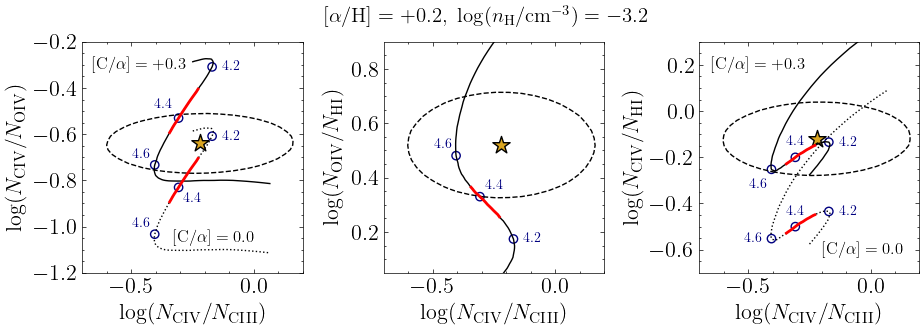

In [13]:
fig, axes = plt.subplots(1,3,figsize=(3.6*3,3), sharex=True)

corner.hist2d(logN_CIV_obs-logN_CIII_obs,logN_CIV_obs-logN_OIV_obs,levels=[2*cdf_1sig-1], bins=50, ax=axes[0], plot_datapoints=False, plot_density=False, contour_kwargs={'linestyles':'--'})
axes[0].scatter(12.78-13.0, 12.78-13.42, marker='*', s=170, edgecolor='black', facecolor='goldenrod')

C_alpha_test = 0.3
logN_HI_test = 12.9

for i in range(len(log_metals_list)):
    
    m = log_metals_list[i]

    logN_CIV_CIII = predict_col_dens_TDP('CIV', m, log_hdens_test, logT_range, logN_HI_test, logX_dict_TDP_interp)-predict_col_dens_TDP('CIII', m, log_hdens_test, logT_range, logN_HI_test, logX_dict_TDP_interp)
    logN_CIV_OIV = predict_col_dens_TDP('CIV', m, log_hdens_test, logT_range, logN_HI_test, logX_dict_TDP_interp)-predict_col_dens_TDP('OIV', m, log_hdens_test, logT_range, logN_HI_test, logX_dict_TDP_interp)

    idx = (logX_CIV_dict[m]>-5)&(logX_CIII_dict[m]>-5)&(logX_OIV_dict[m]>-5)
    axes[i].plot(logN_CIV_CIII[idx], logN_CIV_OIV[idx], color='black', linestyle=':')
    axes[i].plot(logN_CIV_CIII[idx], logN_CIV_OIV[idx]+C_alpha_test, color='black')

    idx_1 = (logX_CIV_dict[m]>-5)&(logX_CIII_dict[m]>-5)&(logX_OIV_dict[m]>-5)&(logT_range>4.37-0.08)&(logT_range<4.37+0.08)
    axes[i].plot(logN_CIV_CIII[idx_1], logN_CIV_OIV[idx_1], color='red', lw=2)
    axes[i].plot(logN_CIV_CIII[idx_1], logN_CIV_OIV[idx_1]+C_alpha_test, color='red', lw=2)
    
    logN_CIV_CIII_plot = predict_col_dens_TDP('CIV', m, log_hdens_test, logT_plot, logN_HI_test, logX_dict_TDP_interp)-predict_col_dens_TDP('CIII', m, log_hdens_test, logT_plot, logN_HI_test, logX_dict_TDP_interp)
    logN_CIV_OIV_plot = predict_col_dens_TDP('CIV', m, log_hdens_test, logT_plot, logN_HI_test, logX_dict_TDP_interp)-predict_col_dens_TDP('OIV', m, log_hdens_test, logT_plot, logN_HI_test, logX_dict_TDP_interp)

    ha = ['left','left','right']
    dx = [0.04, 0.02, -0.02]
    va = ['center','top','bottom']
    dy = [0.0, -0.02, 0.02]
    
    ha_super = ['left','right','right']
    dx_super = [0.04, -0.03, -0.02]
    va_super = ['center','bottom','bottom']
    dy_super = [0.0, 0.03, 0.02]

    for j in range(len(logT_plot)):
        if logX_CIV_plot_dict[m][j]>-5 and logX_CIII_plot_dict[m][j]>-5 and logX_OIV_plot_dict[m][j]>-5:
            
            axes[0].scatter(logN_CIV_CIII_plot[j], logN_CIV_OIV_plot[j], facecolor='none', edgecolor='navy')
            axes[0].scatter(logN_CIV_CIII_plot[j], logN_CIV_OIV_plot[j]+C_alpha_test, facecolor='none', edgecolor='navy')
            
            axes[0].text(logN_CIV_CIII_plot[j]+dx[j], logN_CIV_OIV_plot[j]+dy[j], str(logT_plot[j]), 
                         color='navy', fontsize=10, horizontalalignment=ha[j], verticalalignment=va[j])
            axes[0].text(logN_CIV_CIII_plot[j]+dx_super[j], logN_CIV_OIV_plot[j]+C_alpha_test+dy_super[j], str(logT_plot[j]), 
                         color='navy', fontsize=10, horizontalalignment=ha_super[j], verticalalignment=va_super[j])

axes[0].text(-0.66, -0.3, r'$\mathrm{[C/\alpha]}=+0.3$', fontsize=12, #rotation=60,  
             horizontalalignment='left', verticalalignment='center')

axes[0].text(-0.33, -1.05, r'$\mathrm{[C/\alpha]}=0.0$', fontsize=12, #rotation=60,  
             horizontalalignment='left', verticalalignment='center')

axes[0].set_ylim(-1.2,-0.2)

axes[0].set_xlabel(r'$\log(N_\mathrm{CIV}/N_\mathrm{CIII})$')
axes[0].set_ylabel(r'$\log(N_\mathrm{CIV}/N_\mathrm{OIV})$')

corner.hist2d(logN_CIV_obs-logN_CIII_obs,logN_OIV_obs-logN_HI_obs,levels=[2*cdf_1sig-1], bins=50, ax=axes[1], plot_datapoints=False, plot_density=False, contour_kwargs={'linestyles':'--'})
axes[1].scatter(12.78-13.0, 13.42-12.9, marker='*', s=170, edgecolor='black', facecolor='goldenrod')

for i in range(len(log_metals_list)):
    
    m = log_metals_list[i]

    logN_CIV_CIII = predict_col_dens_TDP('CIV', m, log_hdens_test, logT_range, logN_HI_test, logX_dict_TDP_interp)-predict_col_dens_TDP('CIII', m, log_hdens_test, logT_range, logN_HI_test, logX_dict_TDP_interp)
    logN_OIV_HI = predict_col_dens_TDP('OIV', m, log_hdens_test, logT_range, logN_HI_test, logX_dict_TDP_interp)-logN_HI_test

    idx = (logX_CIV_dict[m]>-5)&(logX_CIII_dict[m]>-5)&(logX_OIV_dict[m]>-5)&(logX_HI_dict[m]>-5)
    axes[1].plot(logN_CIV_CIII[idx], logN_OIV_HI[idx], color='black')
    
    idx_1 = (logX_CIV_dict[m]>-5)&(logX_CIII_dict[m]>-5)&(logX_OIV_dict[m]>-5)&(logX_HI_dict[m]>-5)&(logT_range>4.37-0.08)&(logT_range<4.37+0.08)
    axes[1].plot(logN_CIV_CIII[idx_1], logN_OIV_HI[idx_1], color='red', lw=2)
    
    logN_CIV_CIII_plot = predict_col_dens_TDP('CIV', m, log_hdens_test, logT_plot, logN_HI_test, logX_dict_TDP_interp)-predict_col_dens_TDP('CIII', m, log_hdens_test, logT_plot, logN_HI_test, logX_dict_TDP_interp)
    logN_OIV_HI_plot = predict_col_dens_TDP('OIV', m, log_hdens_test, logT_plot, logN_HI_test, logX_dict_TDP_interp)-logN_HI_test
    
    ha = ['left','left','right']
    dx = [0.04, 0.02, -0.02]
    va = ['center','bottom','bottom']
    dy = [0.0, 0.02, 0.02]    
    
    for j in range(len(logT_plot)):
        if logX_CIV_plot_dict[m][j]>-5 and logX_CIII_plot_dict[m][j]>-5 and logX_OIV_plot_dict[m][j]>-5 and logX_HI_plot_dict[m][j]>-5:
            axes[1].scatter(logN_CIV_CIII_plot[j], logN_OIV_HI_plot[j], facecolor='none', edgecolor='navy')
            axes[1].text(logN_CIV_CIII_plot[j]+dx[j], logN_OIV_HI_plot[j]+dy[j], str(logT_plot[j]), color='navy', fontsize=10, horizontalalignment=ha[j], verticalalignment=va[j])
            
axes[1].set_ylim(0.05,0.9)

axes[1].set_xlabel(r'$\log(N_\mathrm{CIV}/N_\mathrm{CIII})$')
axes[1].set_ylabel(r'$\log(N_\mathrm{OIV}/N_\mathrm{HI})$',labelpad=5)


corner.hist2d(logN_CIV_obs-logN_CIII_obs,logN_CIV_obs-logN_HI_obs,levels=[2*cdf_1sig-1], bins=50, ax=axes[2], plot_datapoints=False, plot_density=False, contour_kwargs={'linestyles':'--'})
axes[2].scatter(12.78-13.0, 12.78-12.9, marker='*', s=170, edgecolor='black', facecolor='goldenrod')

for i in range(len(log_metals_list)):
    
    m = log_metals_list[i]

    logN_CIV_CIII = predict_col_dens_TDP('CIV', m, log_hdens_test, logT_range, logN_HI_test, logX_dict_TDP_interp)-predict_col_dens_TDP('CIII', m, log_hdens_test, logT_range, logN_HI_test, logX_dict_TDP_interp)
    logN_CIV_HI = predict_col_dens_TDP('CIV', m, log_hdens_test, logT_range, logN_HI_test, logX_dict_TDP_interp)-logN_HI_test

    idx = (logX_CIV_dict[m]>-5)&(logX_CIII_dict[m]>-5)&(logX_HI_dict[m]>-5)
    axes[2].plot(logN_CIV_CIII[idx], logN_CIV_HI[idx], color='black', linestyle=':')
    axes[2].plot(logN_CIV_CIII[idx], logN_CIV_HI[idx]+C_alpha_test, color='black')

    idx_1 = (logX_CIV_dict[m]>-5)&(logX_CIII_dict[m]>-5)&(logX_HI_dict[m]>-5)&(logT_range>4.37-0.08)&(logT_range<4.37+0.08)
    axes[2].plot(logN_CIV_CIII[idx_1], logN_CIV_HI[idx_1], color='red', lw=2)
    axes[2].plot(logN_CIV_CIII[idx_1], logN_CIV_HI[idx_1]+C_alpha_test, color='red', lw=2)
    
    logN_CIV_CIII_plot = predict_col_dens_TDP('CIV', m, log_hdens_test, logT_plot, logN_HI_test, logX_dict_TDP_interp)-predict_col_dens_TDP('CIII', m, log_hdens_test, logT_plot, logN_HI_test, logX_dict_TDP_interp)
    logN_CIV_HI_plot = predict_col_dens_TDP('CIV', m, log_hdens_test, logT_plot, logN_HI_test, logX_dict_TDP_interp)-logN_HI_test

    ha = ['left','center','right']
    dx = [0.04, 0.0, -0.04]
    va = ['center','bottom','center']
    dy = [0.0, 0.04, 0.0]
    
    ha_super = ['left','center','right']
    dx_super = [0.04, 0.0, -0.02]
    va_super = ['center','bottom','top']
    dy_super = [0.0, 0.04, -0.04]
    
    for j in range(len(logT_plot)):
        if logX_CIV_plot_dict[m][j]>-5 and logX_CIII_plot_dict[m][j]>-5 and logX_HI_plot_dict[m][j]>-5:
            axes[2].scatter(logN_CIV_CIII_plot[j], logN_CIV_HI_plot[j], facecolor='none', edgecolor='navy')
            axes[2].scatter(logN_CIV_CIII_plot[j], logN_CIV_HI_plot[j]+C_alpha_test, facecolor='none', edgecolor='navy')
            
            axes[2].text(logN_CIV_CIII_plot[j]+dx[j], logN_CIV_HI_plot[j]+dy[j], str(logT_plot[j]), 
                         color='navy', fontsize=10, horizontalalignment=ha[j], verticalalignment=va[j])
            axes[2].text(logN_CIV_CIII_plot[j]+dx_super[j], logN_CIV_HI_plot[j]+C_alpha_test+dy_super[j], str(logT_plot[j]), 
                         color='navy', fontsize=10, horizontalalignment=ha_super[j], verticalalignment=va_super[j])
            
axes[2].set_ylim(-.7,.3)

axes[2].set_xlabel(r'$\log(N_\mathrm{CIV}/N_\mathrm{CIII})$')
axes[2].set_ylabel(r'$\log(N_\mathrm{CIV}/N_\mathrm{HI})$')

axes[2].text(-0.65, 0.2, r'$\mathrm{[C/\alpha]}=+0.3$', fontsize=12, #rotation=60, 
             horizontalalignment='left', verticalalignment='center')

axes[2].text(-0.2, -0.6, r'$\mathrm{[C/\alpha]}=0.0$', fontsize=12, #rotation=60, 
             horizontalalignment='left', verticalalignment='center')

axes[0].set_xlim(-0.7,0.2)

ax_label = fig.add_subplot(111, frameon=False)
ax_label.set_xticks([])
ax_label.set_yticks([])
ax_label.set_title(r'$\mathrm{[\alpha/H]}=+0.2, \ \log(n_\mathrm{H}/\mathrm{cm}^{-3})=-3.2$',
                   fontsize=15, x=0.484, y=1.05)

plt.subplots_adjust(wspace=0.4, hspace=0.0)

pos = axes[1].get_position()
new_pos = [pos.x0-0.0065, pos.y0, pos.width, pos.height]
axes[1].set_position(new_pos)

plt.savefig(savedir+'z_126_c3_diagnostic.pdf', dpi=300)
plt.savefig(savedir+'z_126_c3_diagnostic.png', dpi=300)

# Fit column densities

In [14]:
def log_prior(log_metals, log_hdens, C_O, N_O):
    
    if log_metals_arr[0]<log_metals<log_metals_arr[-1] and -3<log_metals+C_O<1 and -3<log_metals+N_O<1: #[C/H]
        if log_hdens_arr[0]<log_hdens<log_hdens_arr[-1]:
            return 0.
        else:
            return -np.inf
    else:
        return -np.inf

In [15]:
def log_likelihood(log_metals, log_hdens, C_O, N_O, logN_dict, logX_dict_TDP_interp):
    
    logN_HI_obs = logN_HI_test # Measured N(HI) to generate column densities
    
    ll = 0
    
    for ion in list(logN_dict.keys()):
        
        # Model side: prediction adjusted for elemental abundance
        elem = ion_species_dict[ion].split('+')[0]
        
        y_bar = predict_col_dens_TDP(ion, log_metals, log_hdens, logT_test, logN_HI_obs, logX_dict_TDP_interp)
        if elem == 'C':
            y_bar += C_O 
        if elem == 'N':
            y_bar += N_O
            
        # Data side: handle upper limits, lower limits, and measurements separately
        logN_str = logN_dict[ion]
        
        ll += compute_ll(logN_str, y_bar)

    return ll

In [16]:
def log_probability(params, logN_dict, logX_dict_TDP_interp):
    
    log_metals, log_hdens, C_O, N_O = params
    
    lp = log_prior(log_metals,log_hdens,C_O,N_O)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp+log_likelihood(log_metals,log_hdens,C_O,N_O,logN_dict,logX_dict_TDP_interp)

In [17]:
logN_dict = {#'HI':'12.9, -0.1, +0.1',
            'HeI':'<13.3',
            'CII':'<13.3',
            'CIII':'13.0, -0.2, +0.3',
            'CIV':'12.78, -0.03, +0.03',
            'NII':'<13.3',
            'NIII':'<13.2',
            'NIV':'<13.4',
            'OII':'<14.2',
            'OIII':'<13.5',
            'OIV':'13.42, -0.08, +0.08',
            'OV':'<12.7',
            #'OVI':'<13.7',
            #'NeV':'<13.4',
            #'NeVI':'<15.3',
            #'NeVIII':'<13.9',
            #'MgX':'<13.8',
            #'AlII':'<10.9',
            #'AlIII':'<11.4',
            #'SiII':'<19.4?',
            'SiIII':'<11.9',
            'SiIV':'<12.0',
            'SIV':'<12.9',
            'SV':'<12.5',
            'SVI':'<13.4',}
            #'FeII':'<11.5',}

In [18]:
log_metals_test = 0.53
log_hdens_test = -3.1
logT_test = 4.37
logN_HI_test = 12.9
C_O_test = 0.2
N_O_test = -1.0

logN_test = predict_col_dens_model_TDP(logN_dict,log_metals_test,log_hdens_test,logT_test,logN_HI_test,logX_dict_TDP_interp, C_O_test, N_O_test)

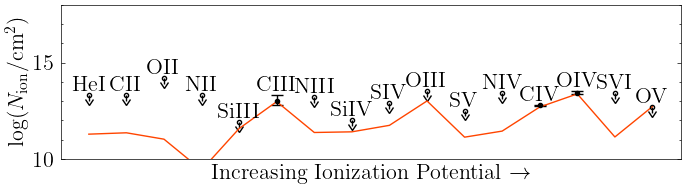

In [19]:
fig, ax = plt.subplots(1, figsize=(8,2))

plot_column_densities_obs(logN_dict, fig, ax)

ax.plot(np.arange(len(logN_dict)), logN_test, color='orangered')

In [20]:
pos = np.array([log_metals_test, log_hdens_test, C_O_test, N_O_test]) + 1e-4 * np.random.randn(200, 4)
nwalkers, ndim = pos.shape

In [21]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(logN_dict, logX_dict_TDP_interp)
)

In [22]:
#sampler.run_mcmc(pos, 500, progress=True);

In [23]:
#flat_samples = pd.DataFrame(sampler.get_chain(discard=100, flat=True), 
#                                columns=['log_metals', 'log_hdens', 'C_O', 'N_O'])
#flat_samples.to_csv(savedir+'TDP_fixT.csv', index=False)

flat_samples = pd.read_csv(savedir+'TDP_fixT.csv')

In [24]:
flat_samples

,log_metals,log_hdens,C_O,N_O
0,0.479633,-3.155211,0.207918,-0.932356
1,0.636472,-2.969940,0.355853,-0.724161
2,0.223455,-3.398855,0.111104,-2.100004
3,0.589859,-3.055786,0.281708,-3.395952
4,0.547873,-3.068706,0.314483,-2.470379
...,...,...,...,...
79995,0.500038,-3.135181,0.290353,-2.998599
79996,0.092990,-3.386660,0.164359,-1.240646
79997,0.791845,-3.080356,0.180036,-3.509363
79998,0.386544,-3.147906,0.362904,-2.488174


In [28]:
flat_samples_modified = pd.DataFrame()
flat_samples_modified['log_hdens'] = flat_samples['log_hdens']
flat_samples_modified['log_metals'] = flat_samples['log_metals']
flat_samples_modified['C_O'] = flat_samples['C_O']
flat_samples_modified['N_O'] = flat_samples['N_O']

In [29]:
flat_samples_modified

,log_hdens,log_metals,C_O,N_O
0,-3.155211,0.479633,0.207918,-0.932356
1,-2.969940,0.636472,0.355853,-0.724161
2,-3.398855,0.223455,0.111104,-2.100004
3,-3.055786,0.589859,0.281708,-3.395952
4,-3.068706,0.547873,0.314483,-2.470379
...,...,...,...,...
79995,-3.135181,0.500038,0.290353,-2.998599
79996,-3.386660,0.092990,0.164359,-1.240646
79997,-3.080356,0.791845,0.180036,-3.509363
79998,-3.147906,0.386544,0.362904,-2.488174


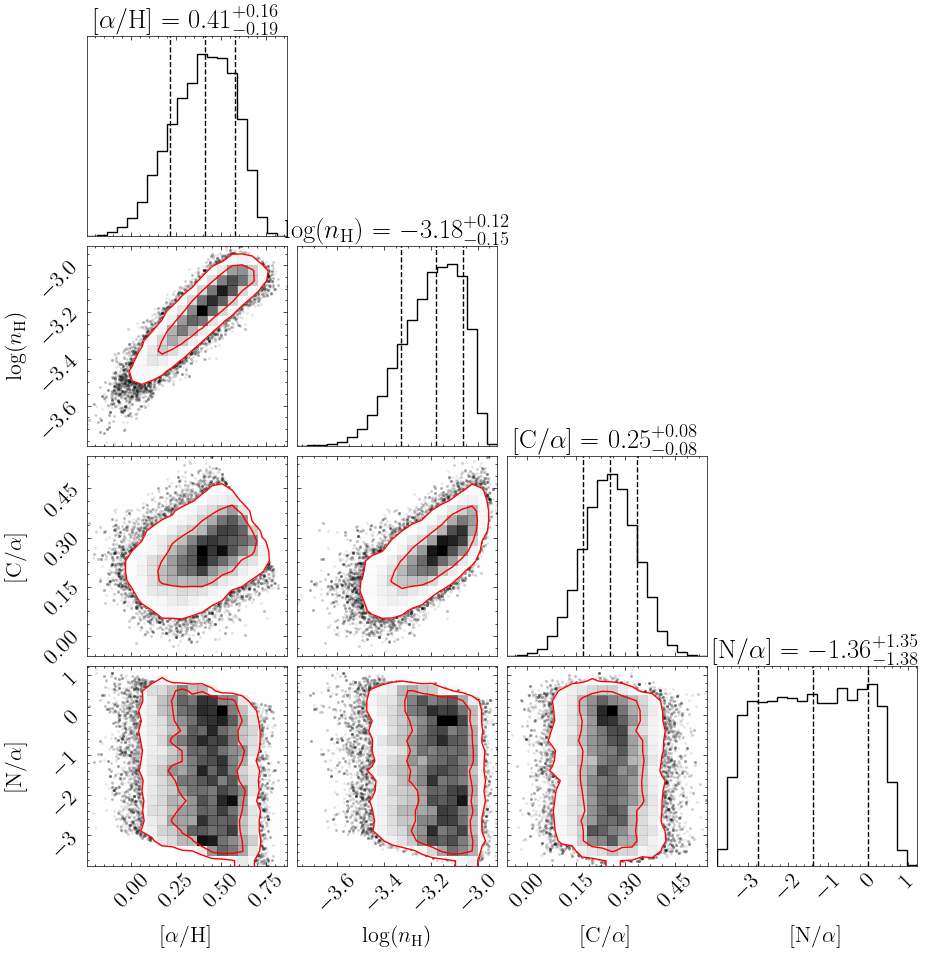

In [24]:
fig = corner.corner(
    flat_samples, quantiles = [0.16, 0.5, 0.84], show_titles=True, 
    labels=[r'$\mathrm{[\alpha/H]}$', r'$\log(n_\mathrm{H})$', r'$\mathrm{[C/\alpha]}$',r'$\mathrm{[N/\alpha]}$'], 
    plot_density=True, levels=[0.68, 0.95], contour_kwargs={'colors':'red'}
);

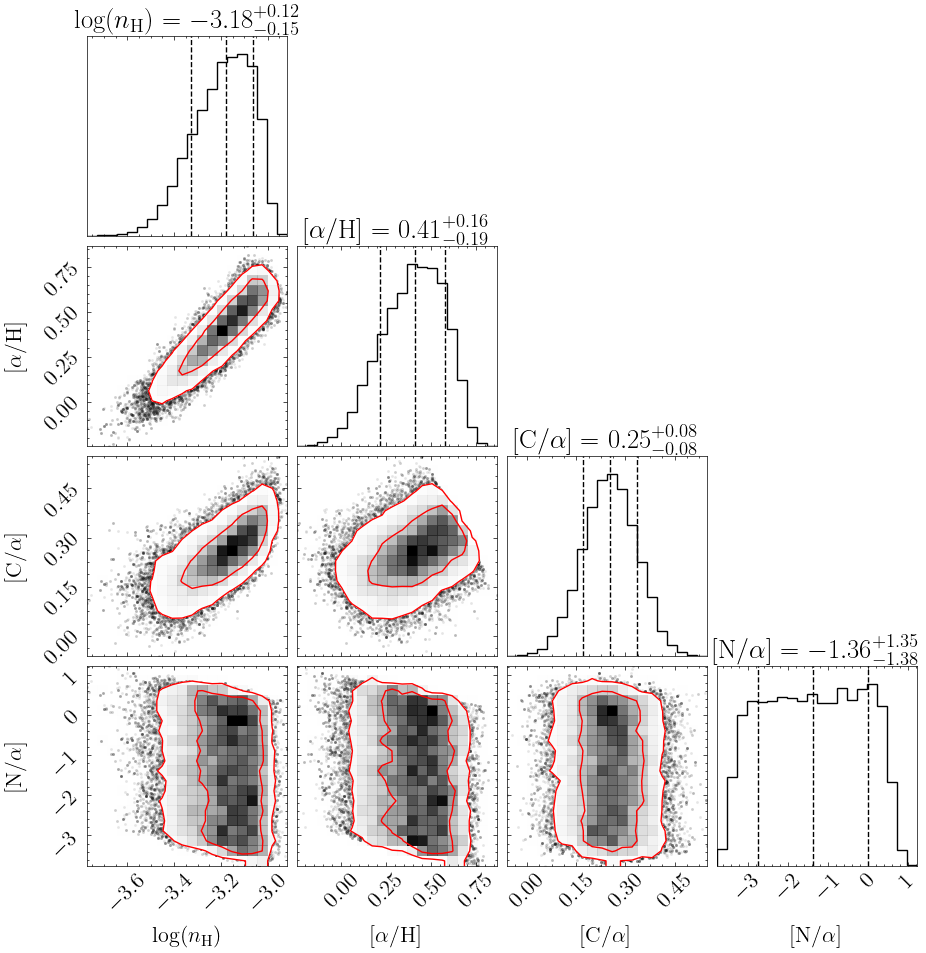

In [30]:
fig = corner.corner(
    flat_samples_modified, quantiles = [0.16, 0.5, 0.84], show_titles=True, 
    labels=[r'$\log(n_\mathrm{H})$', r'$\mathrm{[\alpha/H]}$', r'$\mathrm{[C/\alpha]}$',r'$\mathrm{[N/\alpha]}$'], 
    plot_density=True, levels=[0.68, 0.95], contour_kwargs={'colors':'red'}
);

In [25]:
np.median(flat_samples['log_hdens'])-np.percentile(flat_samples['log_hdens'], 100*(1-cdf_1sig))

0.14834802189095164

In [26]:
np.median(flat_samples['C_O']), np.median(flat_samples['C_O'])-np.percentile(flat_samples['C_O'], 100*(1-cdf_1sig))

(0.2524519144249366, 0.08125211508322178)

In [27]:
np.percentile(flat_samples['N_O'], 100*cdf_3sig)

0.8408655602067125

Make a plot

In [28]:
logN_dict = {#'HI':'12.9, -0.1, +0.1',
            #'HeI':'<13.3',
            #'CII':'<13.3',
            'CIII':'13.0, -0.2, +0.3',
            'CIV':'12.78, -0.03, +0.03',
            #'NII':'<13.3',
            #'NIII':'<13.2',
            'NIV':'<13.4',
            #'OII':'<14.2',
            'OIII':'<13.5',
            'OIV':'13.42, -0.08, +0.08',
            'OV':'<12.7',
            #'OVI':'<13.7',
            #'NeV':'<13.4',
            #'NeVI':'<15.3',
            #'NeVIII':'<13.9',
            #'MgX':'<13.8',
            #'AlII':'<10.9',
            #'AlIII':'<11.4',
            #'SiII':'<19.4?',
            'SiIII':'<11.9',
            'SiIV':'<12.0',}
            #'SIV':'<12.9',
            #'SV':'<12.5',
            #'SVI':'<13.4',}
            #'FeII':'<11.5',}

In [29]:
b_dict = {'HI':'20, -2, +2',
          'CIII':'6.0, -0.7, +0.7',
          'CIV':'6.0, -0.7, +0.7',
          'OIV':'6.0, -0.7, +0.7'}

In [30]:
logN_species_best = predict_col_dens_model_TDP(logN_dict,
                                               np.median(flat_samples['log_metals']),
                                               np.median(flat_samples['log_hdens']),
                                               logT_test,
                                               logN_HI_test,
                                               logX_dict_TDP_interp,
                                               np.median(flat_samples['C_O']),
                                               np.median(flat_samples['N_O']))

In [31]:
logN_res_dict = get_logN_residuals(logN_dict, logN_species_best)

In [32]:
logN_res_up = {k:'<0.8' for k in list(logN_res_dict.keys())}

#logN_res_up['SiIII'] = '<0.4'
logN_res_up['SiIV'] = '<0.4'
logN_res_up['OIII'] = '<0.4'
logN_res_up['NIV'] = '<0.4'

In [33]:
logN_species_grid = np.zeros((len(logN_dict), len(flat_samples)))

ctr = 0

for i in range(len(ion_species_dict)):
    
    ion = list(ion_species_dict.keys())[i]
    
    if ion in list(logN_dict.keys()):
        s = ion_species_dict[ion] # Species, for PIE
        elem = ion_species_dict[ion].split('+')[0] # Element, for non-solar abundances
        
        logN_species_grid[ctr,:] = predict_col_dens_TDP(ion, 
                                      flat_samples['log_metals'],
                                      flat_samples['log_hdens'],
                                      logT_test,
                                      logN_HI_test,
                                      logX_dict_TDP_interp)
        
        if elem == 'C':
            logN_species_grid[ctr,:] += flat_samples['C_O']
            
        if elem == 'N':
            logN_species_grid[ctr,:] += flat_samples['N_O']
            
        ctr += 1

In [34]:
# Draws within 1-sigma of well-constrained values

filtered = []

log_hdens_lo = np.percentile(flat_samples['log_hdens'], 100*(1-cdf_1sig))
log_hdens_hi = np.percentile(flat_samples['log_hdens'], 100*cdf_1sig)

log_metals_lo = np.percentile(flat_samples['log_metals'], 100*(1-cdf_1sig))
log_metals_hi = np.percentile(flat_samples['log_metals'], 100*cdf_1sig)

C_O_lo = np.percentile(flat_samples['C_O'], 100*(1-cdf_1sig))
C_O_hi = np.percentile(flat_samples['C_O'], 100*cdf_1sig)

for i in range(len(flat_samples)):
    log_hdens = flat_samples['log_hdens'][i]
    log_metals = flat_samples['log_metals'][i]
    C_O = flat_samples['C_O'][i]
    N_O = flat_samples['N_O'][i]
    
    if log_hdens_lo<log_hdens<log_hdens_hi and log_metals_lo<log_metals<log_metals_hi and C_O_lo<C_O<C_O_hi:
        filtered.append(i)
        
plot_idx = np.random.randint(0, len(filtered), 50)

In [35]:
import matplotlib.lines as mlines

In [36]:
z_sys = 1.25937492

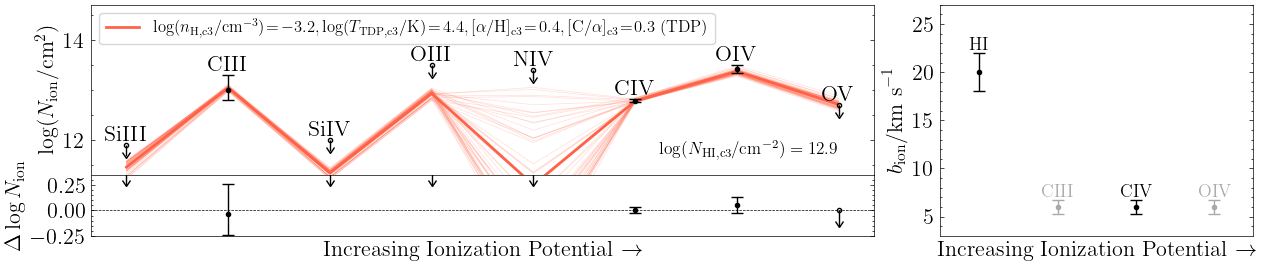

In [37]:
fig, axd = plt.subplot_mosaic([['upper left', 'right'],
                               ['lower left', 'right']],
                               figsize=(15,3.), gridspec_kw={'height_ratios': [2.8,1], 'width_ratios': [2.5, 1]})

for idx in plot_idx:
    axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_grid[:,filtered[idx]], color='tomato', lw=.5, alpha=.2)
    
axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_best, color='tomato', lw=2)

    
plot_column_densities_obs(logN_dict, fig, axd['upper left'],
                          gray_out = ['OVI',
                                     'NeV', 'NeVI'], dy=.15)

axd['upper left'].set_ylim(11.3,14.7)

#axd['upper left'].text(len(logN_dict)-1, 13.7, r'PIE', fontsize=14,horizontalalignment='right')
axd['upper left'].text(len(logN_dict)-1, 11.7, r'$\log(N_\mathrm{HI, c3}/\mathrm{cm}^{-2}) = 12.9$', fontsize=12.5,
            horizontalalignment='right')

handles = []

handles.append(mlines.Line2D([], [], lw=2,
                             color='tomato', 
                             marker='None',
              linestyle='-', markersize=8, label=r'$\log(n_\mathrm{H,c3}/\mathrm{cm}^{-3}) \!=\! -3.2, \log(T_\mathrm{TDP,c3}/\mathrm{K})\!=\!4.4, \mathrm{[\alpha/H]_{c3}} \!=\! 0.4, \mathrm{[C/\alpha]_{c3}}\!=\!0.3$ (TDP)'))

axd['upper left'].legend(handles=handles, loc='upper left', fontsize=12)

plt.subplots_adjust(wspace=0.12, hspace=0)   

plot_column_densities_obs(logN_res_dict, fig, axd['lower left'],gray_out = ['OVI','NeV', 'NeVI'],label_ions=False,dy=.1)
plot_column_densities_obs(logN_res_up, fig, axd['lower left'],gray_out = ['OVI','NeV', 'NeVI'],label_ions=False,dy=.1)

axd['lower left'].set_ylim(-.25,.35)
axd['lower left'].axhline(0, linestyle='--', lw=.5)
axd['lower left'].set_ylabel(r'$\Delta \log N_\mathrm{ion}$')

plot_linewidth_obs(b_dict, fig, axd['right'], fs=13, gray_out = ['CIII', 'OIV', 'OVI'])
axd['right'].set_xlim(-0.5,len(b_dict)-1+.5)
axd['right'].set_ylim(3,27)
#ax.set_title('Two-phase decomposition for a CIV absorber', fontsize=18)

plt.savefig('/Users/thepoetoftwilight/Documents/Astro/Data/PG1522+101/Ions/z={}/z={}_TDP.pdf'.format(z_sys, str(z_sys).replace('.', '_')), dpi=150)
plt.savefig('/Users/thepoetoftwilight/Documents/Astro/Data/PG1522+101/Ions/z={}/z={}_TDP.png'.format(z_sys, str(z_sys).replace('.', '_')), dpi=150)

Cloud size posterior

In [38]:
logl = get_logl_TDP(flat_samples['log_metals'], flat_samples['log_hdens'], logT_test, logN_HI_test, logX_dict_TDP_interp)

(array([ 2142., 16550., 20610., 17879., 12508.,  6958.,  2554.,   652.,
          118.,    29.]),
 array([-2.31302719, -2.14465285, -1.97627851, -1.80790417, -1.63952983,
        -1.47115549, -1.30278115, -1.13440681, -0.96603246, -0.79765812,
        -0.62928378]),
 <BarContainer object of 10 artists>)

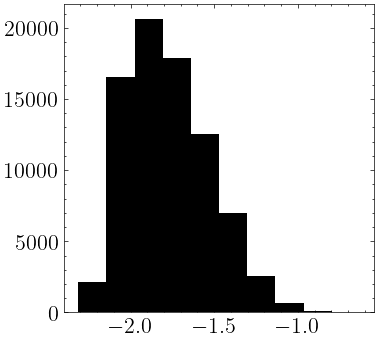

In [39]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.hist(logl)

In [40]:
get_quantiles(logl)

-1.8 -0.23 0.29


# DRAFT

# Fit column densities

In [15]:
def log_prior(log_metals, log_hdens, logT, C_O, N_O):
    
    if log_metals_arr[0]<log_metals<log_metals_arr[-1] and -3<log_metals+C_O<1 and -3<log_metals+N_O<1: #[C/H]
        if log_hdens_arr[0]<log_hdens<log_hdens_arr[-1]:
            if 4.<logT<4.6: # Temperature limit based on CIV linewidth
                return 0.
            else:
                return -np.inf
        else:
            return -np.inf
    else:
        return -np.inf

In [16]:
def log_likelihood(log_metals, log_hdens, logT, C_O, N_O, logN_dict, logX_dict_TDP_interp):
    
    logN_HI_obs = 12.9 # Measured N(HI) to generate column densities
    
    ll = 0
    
    for ion in list(logN_dict.keys()):
        
        # Model side: prediction adjusted for elemental abundance
        elem = ion_species_dict[ion].split('+')[0]
        
        y_bar = predict_col_dens_TDP(ion, log_metals, log_hdens, logT, logN_HI_obs, logX_dict_TDP_interp)
        if elem == 'C':
            y_bar += C_O 
        if elem == 'N':
            y_bar += N_O
            
        # Data side: handle upper limits, lower limits, and measurements separately
        logN_str = logN_dict[ion]
        
        ll += compute_ll(logN_str, y_bar)

    return ll

In [17]:
def log_probability(params, logN_dict, logX_dict_TDP_interp):
    
    log_metals, log_hdens, logT, C_O, N_O = params
    
    lp = log_prior(log_metals,log_hdens,logT,C_O,N_O)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp+log_likelihood(log_metals,log_hdens,logT,C_O,N_O,logN_dict,logX_dict_TDP_interp)

In [18]:
logN_dict = {#'HI':'12.9, -0.2, +0.1',
    'HeI':'<13.1',
    'NII':'<13.3',
    'NIII':'<13.0',
    'NIV':'<12.7',
    'CII':'<13.3',
    'CIII':'13.0, -0.2, +0.2',
    'CIV':'12.76, -0.03, +0.03',
    'OII':'<14.0',
    'OIII':'<13.3',
    'OIV':'13.41, -0.09, +0.07',
    'OV':'<12.7',
    #'OVI':'<13.5',
    #'NeV':'<13.4',
    #'NeVI':'<13.4',
    #'NeVIII':'<13.5',
    #'MgX':'<13.6',
    #'AlII':'<10.9',
    #'AlIII':'<11.4',
    'SiII':'<14.0',
    'SiIII':'<11.9',
    'SiIV':'<12.0',
    'SIV':'<12.9',
    'SV':'<12.5',
    'SVI':'<13.3',}
    #'FeII':'<11.5',}

In [19]:
log_metals_test = 0.5
log_hdens_test = -3.1
logT_test = 4.3
logN_HI_test = 12.9
C_O_test = 0.2
N_O_test = -1.0

logN_test = predict_col_dens_model_TDP(logN_dict,log_metals_test,log_hdens_test,logT_test,logN_HI_test,logX_dict_TDP_interp, C_O_test, N_O_test)

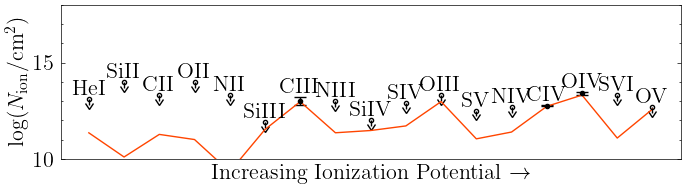

In [20]:
fig, ax = plt.subplots(1, figsize=(8,2))

plot_column_densities_obs(logN_dict, fig, ax)

ax.plot(np.arange(len(logN_dict)), logN_test, color='orangered')

In [21]:
pos = np.array([log_metals_test, log_hdens_test, logT_test, C_O_test, N_O_test]) + 1e-4 * np.random.randn(200, 5)
nwalkers, ndim = pos.shape

In [22]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(logN_dict, logX_dict_TDP_interp)
)

In [23]:
#sampler.run_mcmc(pos, 500, progress=True);

In [24]:
#flat_samples = pd.DataFrame(sampler.get_chain(discard=100, flat=True), 
#                                columns=['log_metals', 'log_hdens', 'logT', 'C_O', 'N_O'])
#flat_samples.to_csv(savedir+'TDP.csv', index=False)

flat_samples = pd.read_csv(savedir+'TDP.csv')

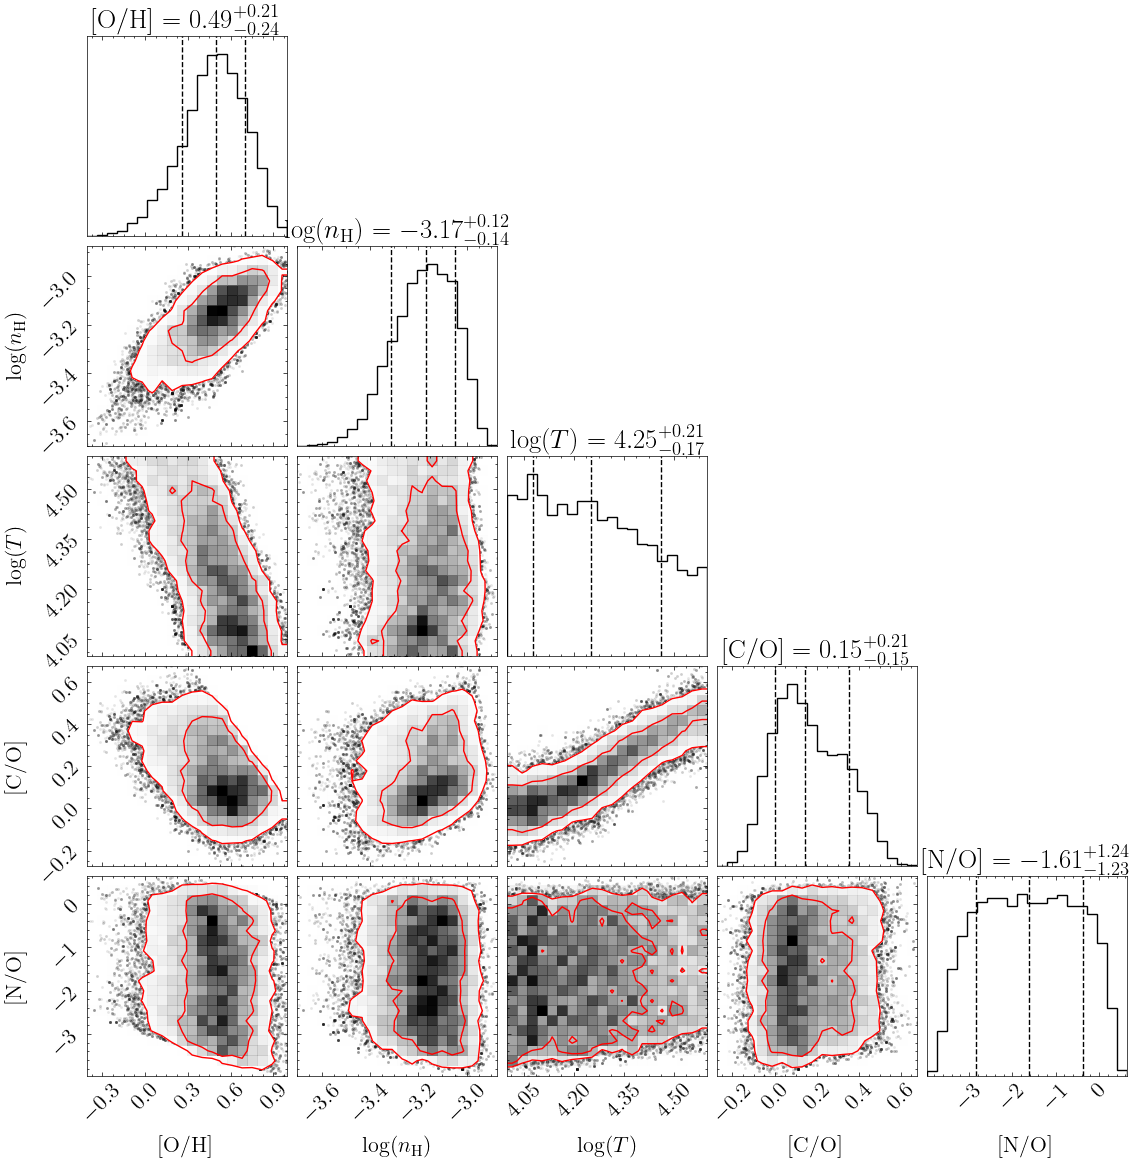

In [25]:
fig = corner.corner(
    flat_samples, quantiles = [0.16, 0.5, 0.84], show_titles=True, 
    labels=[r'$\mathrm{[O/H]}$', r'$\log(n_\mathrm{H})$', r'$\log(T)$', r'$\mathrm{[C/O]}$',r'$\mathrm{[N/O]}$'], 
    plot_density=True, levels=[0.68, 0.95], contour_kwargs={'colors':'red'}
);

In [40]:
np.median(flat_samples['C_O']), np.median(flat_samples['C_O'])-np.percentile(flat_samples['C_O'], 100*(1-cdf_1sig))

(0.1456532247270687, 0.1464919543058254)

In [41]:
np.percentile(flat_samples['logT'], 100*(1-cdf_3sig)), np.percentile(flat_samples['logT'], 100*cdf_3sig)

(4.000845944489305, 4.599085185125179)

In [42]:
np.percentile(flat_samples['N_O'], 100*cdf_3sig)

0.4464030716097886

Make a plot

In [30]:
logN_dict = {#'HI':'12.9, -0.2, +0.1',
    #'HeI':'<13.1',
    #'NII':'<13.3',
    #'NIII':'<13.0',
    #'NIV':'<12.7',
    #'CII':'<13.3',
    'CIII':'13.0, -0.2, +0.2',
    'CIV':'12.76, -0.03, +0.03',
    #'OII':'<14.0',
    'OIII':'<13.3',
    'OIV':'13.41, -0.09, +0.07',
    'OV':'<12.7',
    #'OVI':'<13.5',
    #'NeV':'<13.4',
    #'NeVI':'<13.4',
    #'NeVIII':'<13.5',
    #'MgX':'<13.6',
    #'AlII':'<10.9',
    #'AlIII':'<11.4',
    #'SiII':'<14.0',
    'SiIII':'<11.9',
    'SiIV':'<12.0',}
    #'SIV':'<12.9',
    #'SV':'<12.5',
    #'SVI':'<13.3',}
    #'FeII':'<11.5',}

In [31]:
b_dict = {'HI':'22, -2, +2',
          'CIII':'6.6, -0.6, +0.6',
          'CIV':'6.6, -0.6, +0.6',
          'OIV':'6.6, -0.6, +0.6'}

In [32]:
logN_species_best = predict_col_dens_model_TDP(logN_dict,
                                               np.median(flat_samples['log_metals']),
                                               np.median(flat_samples['log_hdens']),
                                               np.median(flat_samples['logT']),
                                               logN_HI_test,
                                               logX_dict_TDP_interp,
                                               np.median(flat_samples['C_O']),
                                               np.median(flat_samples['N_O']))

In [33]:
logN_res_dict = get_logN_residuals(logN_dict, logN_species_best)

In [54]:
logN_res_up = {k:'<0.8' for k in list(logN_res_dict.keys())}

logN_res_up['SiIII'] = '<0.4'
logN_res_up['SiIV'] = '<0.4'
#logN_res_up['OIII'] = '<0.4'
#logN_res_up['NIV'] = '<0.4'

In [55]:
logN_species_grid = np.zeros((len(logN_dict), len(flat_samples)))

ctr = 0

for i in range(len(ion_species_dict)):
    
    ion = list(ion_species_dict.keys())[i]
    
    if ion in list(logN_dict.keys()):
        s = ion_species_dict[ion] # Species, for PIE
        elem = ion_species_dict[ion].split('+')[0] # Element, for non-solar abundances
        
        logN_species_grid[ctr,:] = predict_col_dens_TDP(ion, 
                                      flat_samples['log_metals'],
                                      flat_samples['log_hdens'],
                                      flat_samples['logT'],
                                      logN_HI_test,
                                      logX_dict_TDP_interp)
        
        if elem == 'C':
            logN_species_grid[ctr,:] += flat_samples['C_O']
            
        if elem == 'N':
            logN_species_grid[ctr,:] += flat_samples['N_O']
            
        ctr += 1

In [56]:
# Draws within 1-sigma of well-constrained values

filtered = []

log_hdens_lo = np.percentile(flat_samples['log_hdens'], 100*(1-cdf_1sig))
log_hdens_hi = np.percentile(flat_samples['log_hdens'], 100*cdf_1sig)

log_metals_lo = np.percentile(flat_samples['log_metals'], 100*(1-cdf_1sig))
log_metals_hi = np.percentile(flat_samples['log_metals'], 100*cdf_1sig)

C_O_lo = np.percentile(flat_samples['C_O'], 100*(1-cdf_1sig))
C_O_hi = np.percentile(flat_samples['C_O'], 100*cdf_1sig)

N_O_lo = np.percentile(flat_samples['N_O'], 100*(1-cdf_1sig))
N_O_hi = np.percentile(flat_samples['N_O'], 100*cdf_1sig)

for i in range(len(flat_samples)):
    log_hdens = flat_samples['log_hdens'][i]
    log_metals = flat_samples['log_metals'][i]
    C_O = flat_samples['C_O'][i]
    N_O = flat_samples['N_O'][i]
    
    if log_hdens_lo<log_hdens<log_hdens_hi and log_metals_lo<log_metals<log_metals_hi and C_O_lo<C_O<C_O_hi and N_O_lo<N_O<N_O_hi:
        filtered.append(i)
        
plot_idx = np.random.randint(0, len(filtered), 50)

In [57]:
import matplotlib.lines as mlines

In [58]:
z_sys = 1.25937492

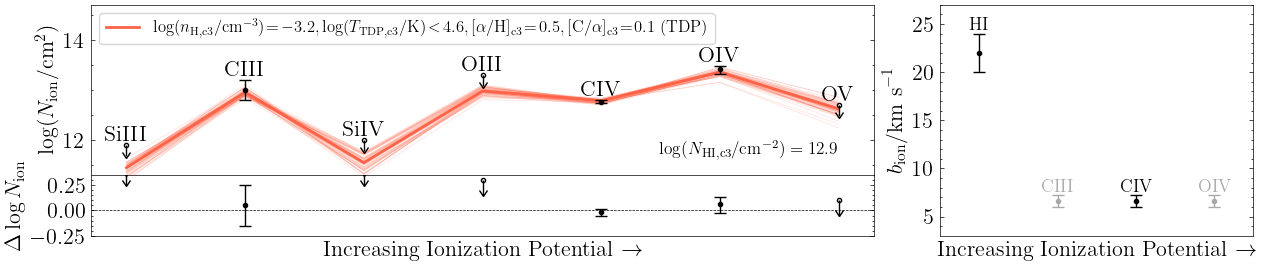

In [65]:
fig, axd = plt.subplot_mosaic([['upper left', 'right'],
                               ['lower left', 'right']],
                               figsize=(15,3.), gridspec_kw={'height_ratios': [2.8,1], 'width_ratios': [2.5, 1]})

for idx in plot_idx:
    axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_grid[:,filtered[idx]], color='tomato', lw=.5, alpha=.2)
    
axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_best, color='tomato', lw=2)

    
plot_column_densities_obs(logN_dict, fig, axd['upper left'],
                          gray_out = ['OVI',
                                     'NeV', 'NeVI'], dy=.15)

axd['upper left'].set_ylim(11.3,14.7)

#axd['upper left'].text(len(logN_dict)-1, 13.7, r'PIE', fontsize=14,horizontalalignment='right')
axd['upper left'].text(len(logN_dict)-1, 11.7, r'$\log(N_\mathrm{HI, c3}/\mathrm{cm}^{-2}) = 12.9$', fontsize=12.5,
            horizontalalignment='right')

handles = []

handles.append(mlines.Line2D([], [], lw=2,
                             color='tomato', 
                             marker='None',
              linestyle='-', markersize=8, label=r'$\log(n_\mathrm{H,c3}/\mathrm{cm}^{-3}) \!=\! -3.2, \log(T_\mathrm{TDP,c3}/\mathrm{K})\!<\!4.6, \mathrm{[\alpha/H]_{c3}} \!=\! 0.5, \mathrm{[C/\alpha]_{c3}}\!=\!0.1$ (TDP)'))

axd['upper left'].legend(handles=handles, loc='upper left', fontsize=12)

plt.subplots_adjust(wspace=0.12, hspace=0)   

plot_column_densities_obs(logN_res_dict, fig, axd['lower left'],gray_out = ['OVI','NeV', 'NeVI'],label_ions=False,dy=.1)
plot_column_densities_obs(logN_res_up, fig, axd['lower left'],gray_out = ['OVI','NeV', 'NeVI'],label_ions=False,dy=.1)

axd['lower left'].set_ylim(-.25,.35)
axd['lower left'].axhline(0, linestyle='--', lw=.5)
axd['lower left'].set_ylabel(r'$\Delta \log N_\mathrm{ion}$')

plot_linewidth_obs(b_dict, fig, axd['right'], fs=13, gray_out = ['CIII', 'OIV', 'OVI'])
axd['right'].set_xlim(-0.5,len(b_dict)-1+.5)
axd['right'].set_ylim(3,27)
#ax.set_title('Two-phase decomposition for a CIV absorber', fontsize=18)

plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z={}/z={}_TDP.pdf'.format(z_sys, str(z_sys).replace('.', '_')), dpi=150)
plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z={}/z={}_TDP.png'.format(z_sys, str(z_sys).replace('.', '_')), dpi=150)

Cloud size posterior

In [62]:
logl = get_logl_TDP(flat_samples['log_metals'], flat_samples['log_hdens'], flat_samples['logT'], logN_HI_test, logX_dict_TDP_interp)

(array([9.3340e+03, 3.2368e+04, 2.8028e+04, 8.7310e+03, 1.3600e+03,
        1.0300e+02, 1.9000e+01, 4.0000e+00, 2.0000e+00, 5.1000e+01]),
 array([-2.5520623 , -2.21647258, -1.88088286, -1.54529314, -1.20970342,
        -0.87411369, -0.53852397, -0.20293425,  0.13265547,  0.46824519,
         0.80383491]),
 <BarContainer object of 10 artists>)

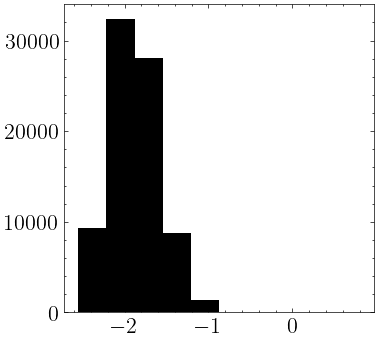

In [63]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.hist(logl)

In [64]:
get_quantiles(logl)

-1.9 -0.27 0.31


## HI

Text(0, 0.5, '$\\log(N_\\mathrm{HI}/\\mathrm{cm}^{-2})$')

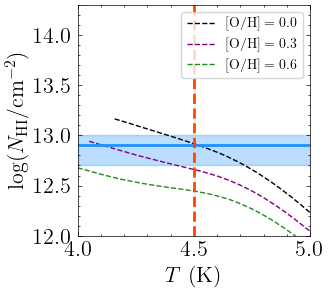

In [14]:
fig, ax = plt.subplots(1, figsize=(3,3))

logT_filt, logN_HI_filt = get_logN_HI('OIV', 13.41, 0, -3.5, logT_arr, logX_dict_TDP_interp)
ax.plot(logT_filt, logN_HI_filt,color='black', linestyle='--', label=r'$\mathrm{[O/H]}=0.0$')

logT_filt, logN_HI_filt = get_logN_HI('OIV', 13.41, 0.3, -3.5, logT_arr, logX_dict_TDP_interp)
ax.plot(logT_filt, logN_HI_filt,color='purple', linestyle='--', label=r'$\mathrm{[O/H]}=0.3$')

logT_filt, logN_HI_filt = get_logN_HI('OIV', 13.41, 0.6, -3.5, logT_arr, logX_dict_TDP_interp)
ax.plot(logT_filt, logN_HI_filt,color='forestgreen', linestyle='--', label=r'$\mathrm{[O/H]}=0.6$')

ax.axhline(12.9, color='dodgerblue', lw=2)
ax.axhspan(12.7,13.0, color='dodgerblue',alpha=.3)
ax.axvline(4.5, color='orangered', lw=2, linestyle='--')

ax.set_xlim(4.0, 5.0)
ax.set_ylim(12, 14.3)

ax.legend(fontsize=10, loc='upper right')
ax.set_xlabel(r'$T \ (\mathrm{K})$')
ax.set_ylabel(r'$\log(N_\mathrm{HI}/\mathrm{cm}^{-2})$')

In [34]:
p_grid = np.array(flat_samples)

yb_med = np.zeros(len(logN_dict))
yb_lo = np.zeros(len(logN_dict))
yb_hi = np.zeros(len(logN_dict))

ctr = 0

for i in range(len(ion_species_dict)):
    
    ion = list(ion_species_dict.keys())[i]
    elem = ion_species_dict[ion].split('+')[0]
    
    if ion in list(logN_dict.keys()):
        
        y_samples = predict_col_dens_TDP(ion, p_grid[:,0], p_grid[:,1], p_grid[:,2], 12.9, logX_dict_TDP_interp)
        if elem == 'C':
            y_samples += p_grid[:,3]
        if elem == 'N':
            y_samples += p_grid[:,4]

        yb_med[ctr] = np.median(y_samples)
        yb_lo[ctr] = np.percentile(y_samples, 16)
        yb_hi[ctr] = np.percentile(y_samples, 84)
        
        ctr += 1

In [35]:
logN_res_dict = get_logN_residuals(logN_dict, yb_med, yb_lo, yb_hi)

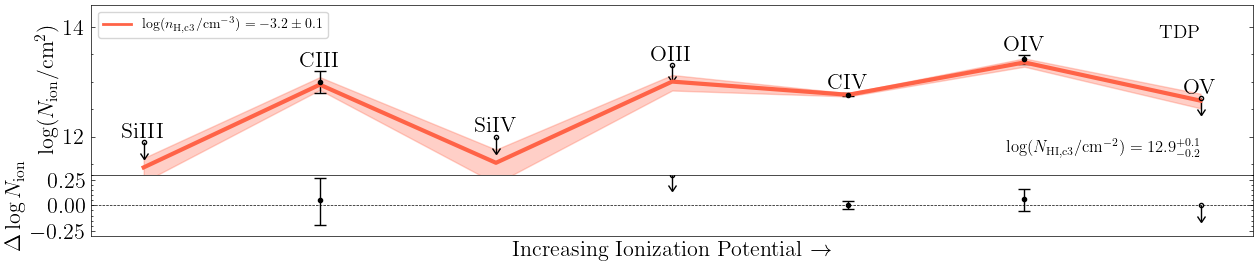

In [38]:
fig, axes = plt.subplots(2, 1, figsize=(15,3.), gridspec_kw={'height_ratios': [2.8, 1]})

plot_column_densities_obs(logN_dict, fig, axes[0],
                   gray_out = ['OVI','NeV', 'NeVI', 'MgII'])

axes[0].plot(np.arange(len(logN_dict)), yb_med, lw=3, color='tomato')
axes[0].fill_between(np.arange(len(logN_dict)), yb_lo, yb_hi, color='tomato', alpha=.3)

axes[0].set_ylim(11.3,14.4)

axes[0].text(len(logN_dict)-1, 13.8, r'TDP', fontsize=14,horizontalalignment='right')

axes[0].text(len(logN_dict)-1, 11.7, r'$\log(N_\mathrm{HI, c3}/\mathrm{cm}^{-2}) = 12.9_{-0.2}^{+0.1}$', fontsize=12,
            horizontalalignment='right')

handles = []

handles.append(mlines.Line2D([], [], lw=2,
                             color='tomato', 
                             marker='None',
              linestyle='-', markersize=8, label=r'$\log(n_\mathrm{H,c3}/\mathrm{cm}^{-3}) = -3.2 \pm 0.1$'))

axes[0].legend(handles=handles, loc='upper left', fontsize=10)

plot_column_densities_obs(logN_res_dict, fig, axes[1], gray_out = ['OVI','NeV', 'NeVI', 'MgII'], label_ions=False, dy=.1)
axes[1].set_ylim(-.3,.3)
axes[1].axhline(0, linestyle='--', lw=.5)
axes[1].set_ylabel(r'$\Delta \log N_\mathrm{ion}$')

plt.subplots_adjust(wspace=0.12, hspace=0) 

#plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z={}/z={}_TDP.pdf'.format(z_sys, str(z_sys).replace('.', '_')), dpi=150)
#plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z={}/z={}_TDP.png'.format(z_sys, str(z_sys).replace('.', '_')), dpi=150)

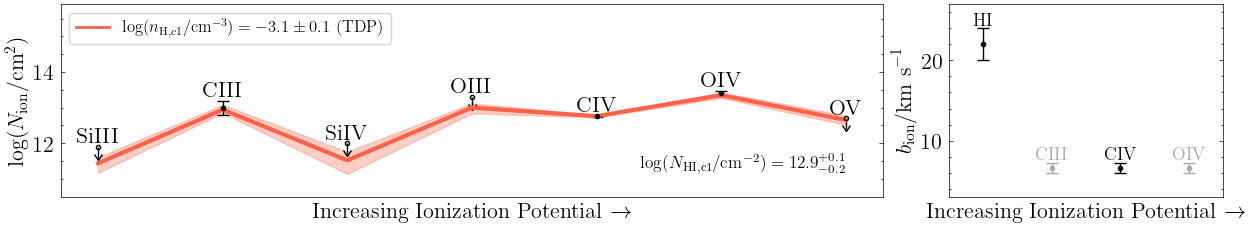

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(15,2.5), gridspec_kw={'width_ratios': [3, 1]})

plot_column_densities_obs(logN_dict, fig, axes[0],
                   gray_out = ['OVI','NeV', 'NeVI', 'MgII'])

axes[0].plot(np.arange(len(logN_dict)), yb_med, lw=3, color='tomato')
axes[0].fill_between(np.arange(len(logN_dict)), yb_lo, yb_hi, color='tomato', alpha=.3)

axes[0].set_ylim(10.5,15.9)


axes[0].text(len(logN_dict)-1, 11.3, r'$\log(N_\mathrm{HI, c1}/\mathrm{cm}^{-2}) = 12.9_{-0.2}^{+0.1}$', fontsize=12.5,
            horizontalalignment='right')

handles = []

handles.append(mlines.Line2D([], [], lw=2,
                             color='tomato', 
                             marker='None',
              linestyle='-', markersize=8, label=r'$\log(n_\mathrm{H,c1}/\mathrm{cm}^{-3}) = -3.1 \pm 0.1$ (TDP)'))

axes[0].legend(handles=handles, loc='upper left', fontsize=12)

plot_linewidth_obs(b_dict, fig, axes[1], fs=13, gray_out = ['CIII', 'OIV', 'OVI'])
axes[1].set_xlim(-0.5,len(b_dict)-1+.5)
axes[1].set_ylim(3,27)

plt.subplots_adjust(wspace=0.12, hspace=0)  

plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z={}/z={}_TDP.pdf'.format(z_sys, str(z_sys).replace('.', '_')), dpi=150)
plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z={}/z={}_TDP.png'.format(z_sys, str(z_sys).replace('.', '_')), dpi=150)

## CIII, CIV, OIV

In [10]:
gen_logN_ratio_str(logN_dict['CIV'], logN_dict['CIII'])

'-0.22, -0.30, 0.20'

In [11]:
logN_ratio_dict = {'CIV/CIII': '-0.22, -0.30, 0.20',
                   'CIV/OIV': '-0.64, -0.09, 0.09',
                  }

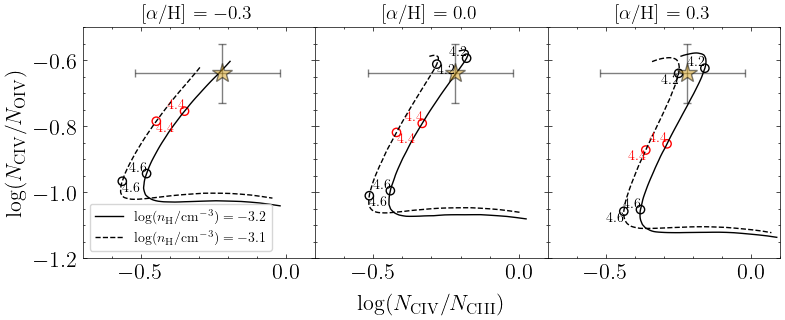

In [12]:
fig, axes = plt.subplots(1,3,figsize=(3*3,3), sharex=True, sharey=True)

ion1 = 'CIII'
ion2 = 'CIV'
ion3 = 'OIV'
ion4 = 'CIV'

# Plot measurements

scat_logN_ratio(axes[0], '{}/{}'.format(ion2, ion1), '{}/{}'.format(ion4, ion3), logN_ratio_dict)
axes[0].set_title(r'$\mathrm{[\alpha/H]}=-0.3$', fontsize=14)

scat_logN_ratio(axes[1], '{}/{}'.format(ion2, ion1), '{}/{}'.format(ion4, ion3), logN_ratio_dict)
axes[1].set_title(r'$\mathrm{[\alpha/H]}=0.0$', fontsize=14)

scat_logN_ratio(axes[2], '{}/{}'.format(ion2, ion1), '{}/{}'.format(ion4, ion3), logN_ratio_dict)
axes[2].set_title(r'$\mathrm{[\alpha/H]}=0.3$', fontsize=14)

ax_label = fig.add_subplot(111, frameon=False)
ax_label.set_xticks([])
ax_label.set_yticks([])

ax_label.set_xlabel(r'$\log(N_\mathrm{CIV}/N_\mathrm{CIII})$', labelpad=25)
ax_label.set_ylabel(r'$\log(N_\mathrm{CIV}/N_\mathrm{OIV})$', labelpad=40)

plt.subplots_adjust(wspace=0, hspace=0.0)

# Plot tracks
# Metallicities and densities
m1 = -0.3
m2 = 0.0
m3 = 0.3

d1 = -3.2
d2 = -3.1
d3 = -2.7

# Temperature range
T_plot_min = 4.0
T_plot_max = 5.0
dT_plot = 0.01

T_mark_min = 4.2
T_mark_max = 4.8
dT_mark = 0.2

# Line width temperature
T_special = 4.4

# Plot range
x_min = -0.7
x_max = 0.1

y_min = -1.2
y_max = -0.5

# Linestyles 
l1 = '-'
l2 = '--'
l3 = ':'

plot_logN_ratio_track(axes[0], ion1, ion2, ion3, ion4, logX_dict_TDP_interp,
                      m1, d1, 
                      T_plot_min, T_plot_max, dT_plot,
                      T_mark_min, T_mark_max, dT_mark,
                      x_min, x_max, y_min, y_max,
                      l1, 'right', 'bottom', T_special)


plot_logN_ratio_track(axes[0], ion1, ion2, ion3, ion4, logX_dict_TDP_interp,
                      m1, d2, 
                      T_plot_min, T_plot_max, dT_plot,
                      T_mark_min, T_mark_max, dT_mark,
                      x_min, x_max, y_min, y_max,
                      l2, 'left', 'top', T_special)

#plot_logN_ratio_track(axes[0], ion1, ion2, ion3, ion4, logX_dict_TDP_interp,
#                      m1, d3, 
#                      T_plot_min, T_plot_max, dT_plot,
#                      T_mark_min, T_mark_max, dT_mark,
#                      x_min, x_max, y_min, y_max,
#                      l3, 'left', 'top')

axes[0].legend(fontsize=10)

# metals = -0.3

plot_logN_ratio_track(axes[1], ion1, ion2, ion3, ion4, logX_dict_TDP_interp,
                      m2, d1, 
                      T_plot_min, T_plot_max, dT_plot,
                      T_mark_min, T_mark_max, dT_mark,
                      x_min, x_max, y_min, y_max,
                      l1, 'right', 'bottom', T_special)

plot_logN_ratio_track(axes[1], ion1, ion2, ion3, ion4, logX_dict_TDP_interp,
                      m2, d2, 
                      T_plot_min, T_plot_max, dT_plot,
                      T_mark_min, T_mark_max, dT_mark,
                      x_min, x_max, y_min, y_max,
                      l2, 'left', 'top', T_special)

#plot_logN_ratio_track(axes[1], ion1, ion2, ion3, ion4, logX_dict_TDP_interp,
#                      m2, d3, 
#                      T_plot_min, T_plot_max, dT_plot,
#                      T_mark_min, T_mark_max, dT_mark,
#                      x_min, x_max, y_min, y_max,
#                      l3, 'left', 'top')

# metals = 0.0

plot_logN_ratio_track(axes[2], ion1, ion2, ion3, ion4, logX_dict_TDP_interp,
                      m3, d1, 
                      T_plot_min, T_plot_max, dT_plot,
                      T_mark_min, T_mark_max, dT_mark,
                      x_min, x_max, y_min, y_max,
                      l1, 'right', 'bottom', T_special)

plot_logN_ratio_track(axes[2], ion1, ion2, ion3, ion4, logX_dict_TDP_interp,
                      m3, d2, 
                      T_plot_min, T_plot_max, dT_plot,
                      T_mark_min, T_mark_max, dT_mark,
                      x_min, x_max, y_min, y_max,
                      l2, 'right', 'top', T_special)

#plot_logN_ratio_track(axes[2], ion1, ion2, ion3, ion4, logX_dict_TDP_interp,
#                      m3, d3, 
#                      T_plot_min, T_plot_max, dT_plot,
#                      T_mark_min, T_mark_max, dT_mark,
#                      x_min, x_max, y_min, y_max,
#                      l3, 'left', 'top')

#plt.savefig(savedir+'z_126_c3_diagnostic.pdf', dpi=300)
#plt.savefig(savedir+'z_126_c3_diagnostic.png', dpi=300)

## CIII, CIV, OIV - v2

In [13]:
log_metals_list = [-0.3, 0.0, 0.3]
log_hdens_test = -3.2
logT_range = np.arange(4.0,5.0,0.01)

logX_CIV_dict = {m:np.zeros(len(logT_range)) for m in log_metals_list}
logX_CIII_dict = {m:np.zeros(len(logT_range)) for m in log_metals_list}
logX_OIV_dict = {m:np.zeros(len(logT_range)) for m in log_metals_list}
logN_OIV_dict = {m:np.zeros(len(logT_range)) for m in log_metals_list}

for m in log_metals_list:
    
    k = (m,log_hdens_test,logT_range)
    logX_CIV = logX_dict_TDP_interp['CIV'](k)
    logX_CIII = logX_dict_TDP_interp['CIII'](k)
    logX_OIV = logX_dict_TDP_interp['OIV'](k)
    logN_OIV = predict_col_dens_TDP('OIV', m, log_hdens_test, logT_range, 12.9, logX_dict_TDP_interp)
    
    logX_CIV_dict[m] = logX_CIV
    logX_CIII_dict[m] = logX_CIII
    logX_OIV_dict[m] = logX_OIV
    logN_OIV_dict[m] = logN_OIV

In [14]:
x = np.random.normal(12.78, 0.03,10000)
y = np.random.normal(13.0, 0.25, 10000)
z = np.random.normal(13.42, 0.08, 10000)

Text(0, 0.5, '$Y=a-c$')

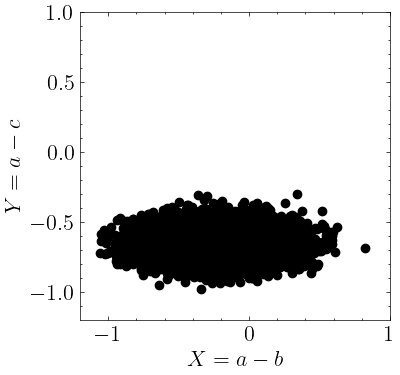

In [15]:
fig, ax = plt.subplots(1,figsize=(4,4))

ax.scatter(x-y,x-z)

ax.set_xlim(-1.2,1.)
ax.set_ylim(-1.2,1.)

ax.set_xlabel(r'$X=a-b$')
ax.set_ylabel(r'$Y=a-c$')

In [16]:
x = np.random.normal(12.78, 0.03, int(2e7))
y = np.random.normal(13.0, 0.25, int(2e7))
z = np.random.normal(13.42, 0.08, int(2e7))

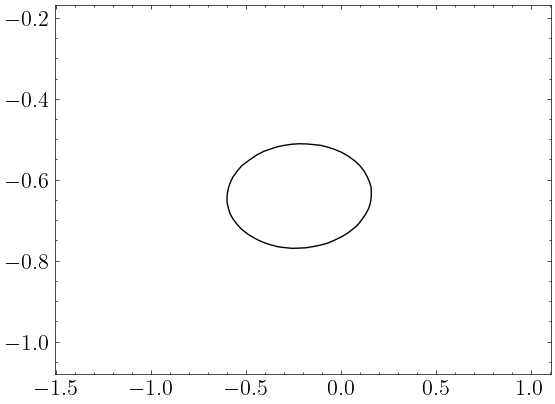

In [17]:
corner.hist2d(x-y,x-z,levels=[2*cdf_1sig-1], bins=70, plot_datapoints=False, plot_density=False)

In [18]:
logT_plot = np.array([4.2,4.6])

logX_CIV_plot_dict = {m:np.zeros(len(logT_plot)) for m in log_metals_list}
logX_CIII_plot_dict = {m:np.zeros(len(logT_plot)) for m in log_metals_list}
logX_OIV_plot_dict = {m:np.zeros(len(logT_plot)) for m in log_metals_list}
logN_OIV_plot_dict = {m:np.zeros(len(logT_plot)) for m in log_metals_list}

for m in log_metals_list:
    
    k = (m,log_hdens_test,logT_plot)
    logX_CIV = logX_dict_TDP_interp['CIV'](k)
    logX_CIII = logX_dict_TDP_interp['CIII'](k)
    logX_OIV = logX_dict_TDP_interp['OIV'](k)
    logN_OIV = predict_col_dens_TDP('OIV', m, log_hdens_test, logT_plot, 12.9, logX_dict_TDP_interp)
    
    logX_CIV_plot_dict[m] = logX_CIV
    logX_CIII_plot_dict[m] = logX_CIII
    logX_OIV_plot_dict[m] = logX_OIV
    logN_OIV_plot_dict[m] = logN_OIV

(-1.1, -0.5)

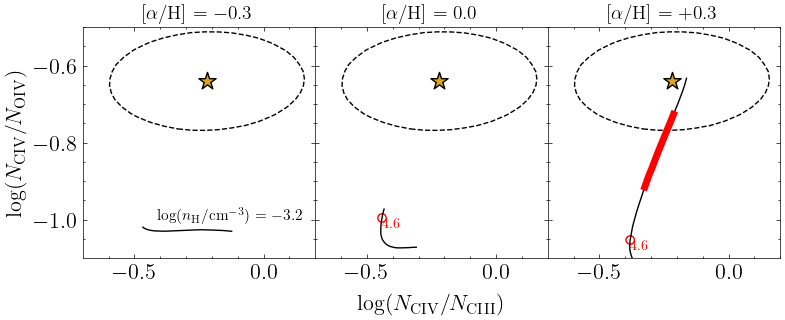

In [19]:
fig, axes = plt.subplots(1,3,figsize=(3*3,3), sharex=True, sharey=True)

corner.hist2d(x-y,x-z,levels=[2*cdf_1sig-1], bins=50, ax=axes[0], plot_datapoints=False, plot_density=False, contour_kwargs={'linestyles':'--'})
axes[0].scatter(12.78-13.0, 12.78-13.42, marker='*', s=170, edgecolor='black', facecolor='goldenrod')

corner.hist2d(x-y,x-z,levels=[2*cdf_1sig-1], bins=50, ax=axes[1], plot_datapoints=False, plot_density=False, contour_kwargs={'linestyles':'--'})
axes[1].scatter(12.78-13.0, 12.78-13.42, marker='*', s=170, edgecolor='black', facecolor='goldenrod')

corner.hist2d(x-y,x-z,levels=[2*cdf_1sig-1], bins=50, ax=axes[2], plot_datapoints=False, plot_density=False, contour_kwargs={'linestyles':'--'})
axes[2].scatter(12.78-13.0, 12.78-13.42, marker='*', s=170, edgecolor='black', facecolor='goldenrod')


axes[0].set_title(r'$\mathrm{[\alpha/H]}=-0.3$', fontsize=14)

axes[1].set_title(r'$\mathrm{[\alpha/H]}=0.0$', fontsize=14)

axes[2].set_title(r'$\mathrm{[\alpha/H]}=+0.3$', fontsize=14)

ax_label = fig.add_subplot(111, frameon=False)
ax_label.set_xticks([])
ax_label.set_yticks([])

ax_label.set_xlabel(r'$\log(N_\mathrm{CIV}/N_\mathrm{CIII})$', labelpad=25)
ax_label.set_ylabel(r'$\log(N_\mathrm{CIV}/N_\mathrm{OIV})$', labelpad=40)

plt.subplots_adjust(wspace=0, hspace=0.0)


for i in range(len(log_metals_list)):
    
    m = log_metals_list[i]

    logN_CIV_CIII = predict_col_dens_TDP('CIV', m, log_hdens_test, logT_range, 12.9, logX_dict_TDP_interp)-predict_col_dens_TDP('CIII', m, log_hdens_test, logT_range, 12.9, logX_dict_TDP_interp)
    logN_CIV_OIV = predict_col_dens_TDP('CIV', m, log_hdens_test, logT_range, 12.9, logX_dict_TDP_interp)-predict_col_dens_TDP('OIV', m, log_hdens_test, logT_range, 12.9, logX_dict_TDP_interp)

    idx = (logX_CIV_dict[m]>-5)&(logX_CIII_dict[m]>-5)&(logX_OIV_dict[m]>-5)&(logN_OIV_dict[m]>13.18)&(logN_OIV_dict[m]<13.66)
    axes[i].plot(logN_CIV_CIII[idx], logN_CIV_OIV[idx], color='black')

    idx_1 = (logX_CIV_dict[m]>-5)&(logX_CIII_dict[m]>-5)&(logX_OIV_dict[m]>-5)&(logN_OIV_dict[m]>13.18)&(logN_OIV_dict[m]<13.66)&(logT_range>4.37-0.08)&(logT_range<4.37+0.08)
    axes[i].plot(logN_CIV_CIII[idx_1], logN_CIV_OIV[idx_1], color='red', lw=5)
    
    logN_CIV_CIII_plot = predict_col_dens_TDP('CIV', m, log_hdens_test, logT_plot, 12.9, logX_dict_TDP_interp)-predict_col_dens_TDP('CIII', m, log_hdens_test, logT_plot, 12.9, logX_dict_TDP_interp)
    logN_CIV_OIV_plot = predict_col_dens_TDP('CIV', m, log_hdens_test, logT_plot, 12.9, logX_dict_TDP_interp)-predict_col_dens_TDP('OIV', m, log_hdens_test, logT_plot, 12.9, logX_dict_TDP_interp)

    for j in range(len(logT_plot)):
        if logX_CIV_plot_dict[m][j]>-5 and logX_CIII_plot_dict[m][j]>-5 and logX_OIV_plot_dict[m][j]>-5 and logN_OIV_plot_dict[m][j]>13.18 and logN_OIV_plot_dict[m][j]<13.66:
            axes[i].scatter(logN_CIV_CIII_plot[j], logN_CIV_OIV_plot[j], facecolor='none', edgecolor='red')
            axes[i].text(logN_CIV_CIII_plot[j], logN_CIV_OIV_plot[j], str(logT_plot[j]), color='red', fontsize=10, horizontalalignment='left', verticalalignment='top')
    
axes[0].text(0.15, -1.0, r'$\log(n_\mathrm{H}/\mathrm{cm}^{-3}) = -3.2$', fontsize=11, horizontalalignment='right')
    
axes[0].set_xlim(-0.7,0.2)
axes[0].set_ylim(-1.1,-0.5)

#plt.savefig(savedir+'z_126_c3_diagnostic.pdf', dpi=300)
#plt.savefig(savedir+'z_126_c3_diagnostic.png', dpi=300)

## CIII, CIV, OIV, HI

In [20]:
log_metals_list = [-0.3, 0.0, 0.3]
log_hdens_test = -3.2
logT_range = np.arange(4.0,5.0,0.01)

logX_CIV_dict = {m:np.zeros(len(logT_range)) for m in log_metals_list}
logX_CIII_dict = {m:np.zeros(len(logT_range)) for m in log_metals_list}
logX_OIV_dict = {m:np.zeros(len(logT_range)) for m in log_metals_list}
logX_HI_dict = {m:np.zeros(len(logT_range)) for m in log_metals_list}

for m in log_metals_list:
    
    k = (m,log_hdens_test,logT_range)
    logX_CIV = logX_dict_TDP_interp['CIV'](k)
    logX_CIII = logX_dict_TDP_interp['CIII'](k)
    logX_OIV = logX_dict_TDP_interp['OIV'](k)
    logX_HI = logX_dict_TDP_interp['HI'](k)
    
    logX_CIV_dict[m] = logX_CIV
    logX_CIII_dict[m] = logX_CIII
    logX_OIV_dict[m] = logX_OIV
    logX_HI_dict[m] = logX_HI

In [21]:
logT_plot = np.array([4.2,4.6])

logX_CIV_plot_dict = {m:np.zeros(len(logT_plot)) for m in log_metals_list}
logX_CIII_plot_dict = {m:np.zeros(len(logT_plot)) for m in log_metals_list}
logX_OIV_plot_dict = {m:np.zeros(len(logT_plot)) for m in log_metals_list}
logX_HI_plot_dict = {m:np.zeros(len(logT_plot)) for m in log_metals_list}

for m in log_metals_list:
    
    k = (m,log_hdens_test,logT_plot)
    logX_CIV = logX_dict_TDP_interp['CIV'](k)
    logX_CIII = logX_dict_TDP_interp['CIII'](k)
    logX_OIV = logX_dict_TDP_interp['OIV'](k)
    logX_HI = logX_dict_TDP_interp['HI'](k)
    
    logX_CIV_plot_dict[m] = logX_CIV
    logX_CIII_plot_dict[m] = logX_CIII
    logX_OIV_plot_dict[m] = logX_OIV
    logX_HI_plot_dict[m] = logX_HI

In [22]:
logN_CIV_obs = np.random.normal(12.78, 0.03,int(2e7))
logN_CIII_obs = np.random.normal(13.0, 0.25, int(2e7))
logN_OIV_obs = np.random.normal(13.42, 0.08, int(2e7))
logN_HI_obs = np.random.normal(12.9, 0.1, int(2e7))

(0.0, 1.0)

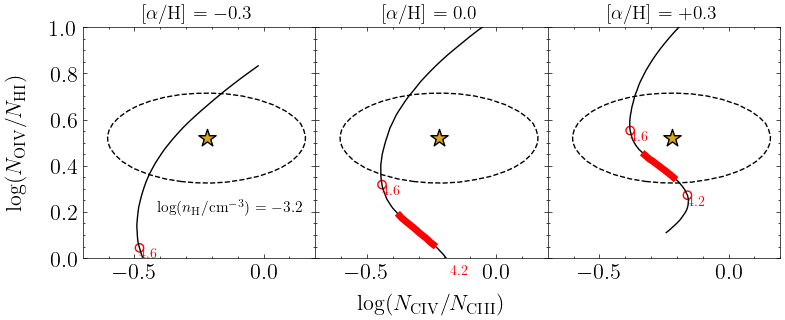

In [23]:
fig, axes = plt.subplots(1,3,figsize=(3*3,3), sharex=True, sharey=True)

corner.hist2d(logN_CIV_obs-logN_CIII_obs,logN_OIV_obs-logN_HI_obs,levels=[2*cdf_1sig-1], bins=50, ax=axes[0], plot_datapoints=False, plot_density=False, contour_kwargs={'linestyles':'--'})
axes[0].scatter(12.78-13.0, 13.42-12.9, marker='*', s=170, edgecolor='black', facecolor='goldenrod')

corner.hist2d(logN_CIV_obs-logN_CIII_obs,logN_OIV_obs-logN_HI_obs,levels=[2*cdf_1sig-1], bins=50, ax=axes[1], plot_datapoints=False, plot_density=False, contour_kwargs={'linestyles':'--'})
axes[1].scatter(12.78-13.0, 13.42-12.9, marker='*', s=170, edgecolor='black', facecolor='goldenrod')

corner.hist2d(logN_CIV_obs-logN_CIII_obs,logN_OIV_obs-logN_HI_obs,levels=[2*cdf_1sig-1], bins=50, ax=axes[2], plot_datapoints=False, plot_density=False, contour_kwargs={'linestyles':'--'})
axes[2].scatter(12.78-13.0, 13.42-12.9, marker='*', s=170, edgecolor='black', facecolor='goldenrod')


axes[0].set_title(r'$\mathrm{[\alpha/H]}=-0.3$', fontsize=14)

axes[1].set_title(r'$\mathrm{[\alpha/H]}=0.0$', fontsize=14)

axes[2].set_title(r'$\mathrm{[\alpha/H]}=+0.3$', fontsize=14)

ax_label = fig.add_subplot(111, frameon=False)
ax_label.set_xticks([])
ax_label.set_yticks([])

ax_label.set_xlabel(r'$\log(N_\mathrm{CIV}/N_\mathrm{CIII})$', labelpad=25)
ax_label.set_ylabel(r'$\log(N_\mathrm{OIV}/N_\mathrm{HI})$', labelpad=40)

plt.subplots_adjust(wspace=0, hspace=0.0)


for i in range(len(log_metals_list)):
    
    m = log_metals_list[i]

    logN_CIV_CIII = predict_col_dens_TDP('CIV', m, log_hdens_test, logT_range, 12.9, logX_dict_TDP_interp)-predict_col_dens_TDP('CIII', m, log_hdens_test, logT_range, 12.9, logX_dict_TDP_interp)
    logN_OIV_HI = predict_col_dens_TDP('OIV', m, log_hdens_test, logT_range, 12.9, logX_dict_TDP_interp)-12.9

    idx = (logX_CIV_dict[m]>-5)&(logX_CIII_dict[m]>-5)&(logX_OIV_dict[m]>-5)&(logX_HI_dict[m]>-5)
    axes[i].plot(logN_CIV_CIII[idx], logN_OIV_HI[idx], color='black')

    idx_1 = (logX_CIV_dict[m]>-5)&(logX_CIII_dict[m]>-5)&(logX_OIV_dict[m]>-5)&(logX_HI_dict[m]>-5)&(logT_range>4.37-0.08)&(logT_range<4.37+0.08)
    axes[i].plot(logN_CIV_CIII[idx_1], logN_OIV_HI[idx_1], color='red', lw=5)
    
    logN_CIV_CIII_plot = predict_col_dens_TDP('CIV', m, log_hdens_test, logT_plot, 12.9, logX_dict_TDP_interp)-predict_col_dens_TDP('CIII', m, log_hdens_test, logT_plot, 12.9, logX_dict_TDP_interp)
    logN_OIV_HI_plot = predict_col_dens_TDP('OIV', m, log_hdens_test, logT_plot, 12.9, logX_dict_TDP_interp)-12.9

    for j in range(len(logT_plot)):
        if logX_CIV_plot_dict[m][j]>-5 and logX_CIII_plot_dict[m][j]>-5 and logX_OIV_plot_dict[m][j]>-5 and logX_HI_plot_dict[m][j]>-5:
            axes[i].scatter(logN_CIV_CIII_plot[j], logN_OIV_HI_plot[j], facecolor='none', edgecolor='red')
            axes[i].text(logN_CIV_CIII_plot[j], logN_OIV_HI_plot[j], str(logT_plot[j]), color='red', fontsize=10, horizontalalignment='left', verticalalignment='top')
    
axes[0].text(0.15, 0.2, r'$\log(n_\mathrm{H}/\mathrm{cm}^{-3}) = -3.2$', fontsize=11, horizontalalignment='right')
    
axes[0].set_xlim(-0.7,0.2)
axes[0].set_ylim(0.0,1.0)

#plt.savefig(savedir+'z_126_c3_diagnostic.pdf', dpi=300)
#plt.savefig(savedir+'z_126_c3_diagnostic.png', dpi=300)

## CIII, CIV, OIV, HI - v2

In [24]:
log_metals_list = [0.2]
log_hdens_test = -3.2
logT_range = np.arange(4.0,5.0,0.01)

logX_CIV_dict = {m:np.zeros(len(logT_range)) for m in log_metals_list}
logX_CIII_dict = {m:np.zeros(len(logT_range)) for m in log_metals_list}
logX_OIV_dict = {m:np.zeros(len(logT_range)) for m in log_metals_list}
logX_HI_dict = {m:np.zeros(len(logT_range)) for m in log_metals_list}

for m in log_metals_list:
    
    k = (m,log_hdens_test,logT_range)
    logX_CIV = logX_dict_TDP_interp['CIV'](k)
    logX_CIII = logX_dict_TDP_interp['CIII'](k)
    logX_OIV = logX_dict_TDP_interp['OIV'](k)
    logX_HI = logX_dict_TDP_interp['HI'](k)
    
    logX_CIV_dict[m] = logX_CIV
    logX_CIII_dict[m] = logX_CIII
    logX_OIV_dict[m] = logX_OIV
    logX_HI_dict[m] = logX_HI

In [25]:
logT_plot = np.array([4.2,4.6])

logX_CIV_plot_dict = {m:np.zeros(len(logT_plot)) for m in log_metals_list}
logX_CIII_plot_dict = {m:np.zeros(len(logT_plot)) for m in log_metals_list}
logX_OIV_plot_dict = {m:np.zeros(len(logT_plot)) for m in log_metals_list}
logX_HI_plot_dict = {m:np.zeros(len(logT_plot)) for m in log_metals_list}

for m in log_metals_list:
    
    k = (m,log_hdens_test,logT_plot)
    logX_CIV = logX_dict_TDP_interp['CIV'](k)
    logX_CIII = logX_dict_TDP_interp['CIII'](k)
    logX_OIV = logX_dict_TDP_interp['OIV'](k)
    logX_HI = logX_dict_TDP_interp['HI'](k)
    
    logX_CIV_plot_dict[m] = logX_CIV
    logX_CIII_plot_dict[m] = logX_CIII
    logX_OIV_plot_dict[m] = logX_OIV
    logX_HI_plot_dict[m] = logX_HI

In [26]:
logN_CIV_obs = np.random.normal(12.78, 0.03,int(2e7))
logN_CIII_obs = np.random.normal(13.0, 0.25, int(2e7))
logN_OIV_obs = np.random.normal(13.42, 0.08, int(2e7))
logN_HI_obs = np.random.normal(12.9, 0.1, int(2e7))

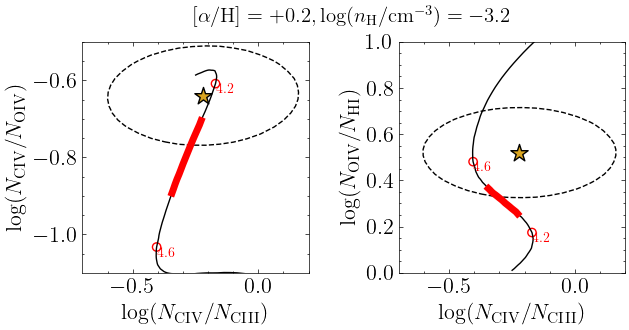

In [52]:
fig, axes = plt.subplots(1,2,figsize=(3.5*2,3), sharex=True)

corner.hist2d(logN_CIV_obs-logN_CIII_obs,logN_CIV_obs-logN_OIV_obs,levels=[2*cdf_1sig-1], bins=50, ax=axes[0], plot_datapoints=False, plot_density=False, contour_kwargs={'linestyles':'--'})
axes[0].scatter(12.78-13.0, 12.78-13.42, marker='*', s=170, edgecolor='black', facecolor='goldenrod')

for i in range(len(log_metals_list)):
    
    m = log_metals_list[i]

    logN_CIV_CIII = predict_col_dens_TDP('CIV', m, log_hdens_test, logT_range, 12.9, logX_dict_TDP_interp)-predict_col_dens_TDP('CIII', m, log_hdens_test, logT_range, 12.9, logX_dict_TDP_interp)
    logN_CIV_OIV = predict_col_dens_TDP('CIV', m, log_hdens_test, logT_range, 12.9, logX_dict_TDP_interp)-predict_col_dens_TDP('OIV', m, log_hdens_test, logT_range, 12.9, logX_dict_TDP_interp)

    idx = (logX_CIV_dict[m]>-5)&(logX_CIII_dict[m]>-5)&(logX_OIV_dict[m]>-5)
    axes[i].plot(logN_CIV_CIII[idx], logN_CIV_OIV[idx], color='black')

    idx_1 = (logX_CIV_dict[m]>-5)&(logX_CIII_dict[m]>-5)&(logX_OIV_dict[m]>-5)&(logT_range>4.37-0.08)&(logT_range<4.37+0.08)
    axes[i].plot(logN_CIV_CIII[idx_1], logN_CIV_OIV[idx_1], color='red', lw=5)
    
    logN_CIV_CIII_plot = predict_col_dens_TDP('CIV', m, log_hdens_test, logT_plot, 12.9, logX_dict_TDP_interp)-predict_col_dens_TDP('CIII', m, log_hdens_test, logT_plot, 12.9, logX_dict_TDP_interp)
    logN_CIV_OIV_plot = predict_col_dens_TDP('CIV', m, log_hdens_test, logT_plot, 12.9, logX_dict_TDP_interp)-predict_col_dens_TDP('OIV', m, log_hdens_test, logT_plot, 12.9, logX_dict_TDP_interp)

    for j in range(len(logT_plot)):
        if logX_CIV_plot_dict[m][j]>-5 and logX_CIII_plot_dict[m][j]>-5 and logX_OIV_plot_dict[m][j]>-5:
            axes[0].scatter(logN_CIV_CIII_plot[j], logN_CIV_OIV_plot[j], facecolor='none', edgecolor='red')
            axes[0].text(logN_CIV_CIII_plot[j], logN_CIV_OIV_plot[j], str(logT_plot[j]), color='red', fontsize=10, horizontalalignment='left', verticalalignment='top')

axes[0].set_ylim(-1.1,-0.5)

axes[0].set_xlabel(r'$\log(N_\mathrm{CIV}/N_\mathrm{CIII})$')
axes[0].set_ylabel(r'$\log(N_\mathrm{CIV}/N_\mathrm{OIV})$')

corner.hist2d(logN_CIV_obs-logN_CIII_obs,logN_OIV_obs-logN_HI_obs,levels=[2*cdf_1sig-1], bins=50, ax=axes[1], plot_datapoints=False, plot_density=False, contour_kwargs={'linestyles':'--'})
axes[1].scatter(12.78-13.0, 13.42-12.9, marker='*', s=170, edgecolor='black', facecolor='goldenrod')

for i in range(len(log_metals_list)):
    
    m = log_metals_list[i]

    logN_CIV_CIII = predict_col_dens_TDP('CIV', m, log_hdens_test, logT_range, 12.9, logX_dict_TDP_interp)-predict_col_dens_TDP('CIII', m, log_hdens_test, logT_range, 12.9, logX_dict_TDP_interp)
    logN_OIV_HI = predict_col_dens_TDP('OIV', m, log_hdens_test, logT_range, 12.9, logX_dict_TDP_interp)-12.9

    idx = (logX_CIV_dict[m]>-5)&(logX_CIII_dict[m]>-5)&(logX_OIV_dict[m]>-5)&(logX_HI_dict[m]>-5)
    axes[1].plot(logN_CIV_CIII[idx], logN_OIV_HI[idx], color='black')

    idx_1 = (logX_CIV_dict[m]>-5)&(logX_CIII_dict[m]>-5)&(logX_OIV_dict[m]>-5)&(logX_HI_dict[m]>-5)&(logT_range>4.37-0.08)&(logT_range<4.37+0.08)
    axes[1].plot(logN_CIV_CIII[idx_1], logN_OIV_HI[idx_1], color='red', lw=5)
    
    logN_CIV_CIII_plot = predict_col_dens_TDP('CIV', m, log_hdens_test, logT_plot, 12.9, logX_dict_TDP_interp)-predict_col_dens_TDP('CIII', m, log_hdens_test, logT_plot, 12.9, logX_dict_TDP_interp)
    logN_OIV_HI_plot = predict_col_dens_TDP('OIV', m, log_hdens_test, logT_plot, 12.9, logX_dict_TDP_interp)-12.9

    for j in range(len(logT_plot)):
        if logX_CIV_plot_dict[m][j]>-5 and logX_CIII_plot_dict[m][j]>-5 and logX_OIV_plot_dict[m][j]>-5 and logX_HI_plot_dict[m][j]>-5:
            axes[1].scatter(logN_CIV_CIII_plot[j], logN_OIV_HI_plot[j], facecolor='none', edgecolor='red')
            axes[1].text(logN_CIV_CIII_plot[j], logN_OIV_HI_plot[j], str(logT_plot[j]), color='red', fontsize=10, horizontalalignment='left', verticalalignment='top')
            
axes[1].set_ylim(0.0,1.0)

axes[1].set_xlabel(r'$\log(N_\mathrm{CIV}/N_\mathrm{CIII})$')
axes[1].set_ylabel(r'$\log(N_\mathrm{OIV}/N_\mathrm{HI})$')

axes[0].set_xlim(-0.7,0.2)

ax_label = fig.add_subplot(111, frameon=False)
ax_label.set_xticks([])
ax_label.set_yticks([])
ax_label.set_title(r'$\mathrm{[\alpha/H]}=+0.2, \log(n_\mathrm{H}/\mathrm{cm}^{-3})=-3.2$',fontsize=15, y=1.05)

plt.subplots_adjust(wspace=0.4, hspace=0.0)

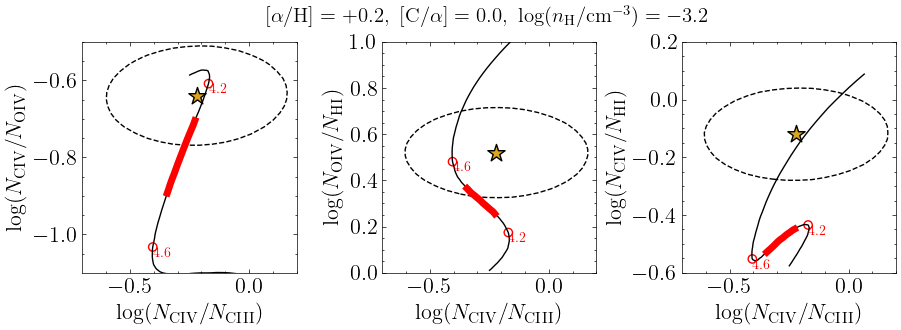

In [63]:
fig, axes = plt.subplots(1,3,figsize=(3.5*3,3), sharex=True)

corner.hist2d(logN_CIV_obs-logN_CIII_obs,logN_CIV_obs-logN_OIV_obs,levels=[2*cdf_1sig-1], bins=50, ax=axes[0], plot_datapoints=False, plot_density=False, contour_kwargs={'linestyles':'--'})
axes[0].scatter(12.78-13.0, 12.78-13.42, marker='*', s=170, edgecolor='black', facecolor='goldenrod')

for i in range(len(log_metals_list)):
    
    m = log_metals_list[i]

    logN_CIV_CIII = predict_col_dens_TDP('CIV', m, log_hdens_test, logT_range, 12.9, logX_dict_TDP_interp)-predict_col_dens_TDP('CIII', m, log_hdens_test, logT_range, 12.9, logX_dict_TDP_interp)
    logN_CIV_OIV = predict_col_dens_TDP('CIV', m, log_hdens_test, logT_range, 12.9, logX_dict_TDP_interp)-predict_col_dens_TDP('OIV', m, log_hdens_test, logT_range, 12.9, logX_dict_TDP_interp)

    idx = (logX_CIV_dict[m]>-5)&(logX_CIII_dict[m]>-5)&(logX_OIV_dict[m]>-5)
    axes[i].plot(logN_CIV_CIII[idx], logN_CIV_OIV[idx], color='black')

    idx_1 = (logX_CIV_dict[m]>-5)&(logX_CIII_dict[m]>-5)&(logX_OIV_dict[m]>-5)&(logT_range>4.37-0.08)&(logT_range<4.37+0.08)
    axes[i].plot(logN_CIV_CIII[idx_1], logN_CIV_OIV[idx_1], color='red', lw=5)
    
    logN_CIV_CIII_plot = predict_col_dens_TDP('CIV', m, log_hdens_test, logT_plot, 12.9, logX_dict_TDP_interp)-predict_col_dens_TDP('CIII', m, log_hdens_test, logT_plot, 12.9, logX_dict_TDP_interp)
    logN_CIV_OIV_plot = predict_col_dens_TDP('CIV', m, log_hdens_test, logT_plot, 12.9, logX_dict_TDP_interp)-predict_col_dens_TDP('OIV', m, log_hdens_test, logT_plot, 12.9, logX_dict_TDP_interp)

    for j in range(len(logT_plot)):
        if logX_CIV_plot_dict[m][j]>-5 and logX_CIII_plot_dict[m][j]>-5 and logX_OIV_plot_dict[m][j]>-5:
            axes[0].scatter(logN_CIV_CIII_plot[j], logN_CIV_OIV_plot[j], facecolor='none', edgecolor='red')
            axes[0].text(logN_CIV_CIII_plot[j], logN_CIV_OIV_plot[j], str(logT_plot[j]), color='red', fontsize=10, horizontalalignment='left', verticalalignment='top')

axes[0].set_ylim(-1.1,-0.5)

axes[0].set_xlabel(r'$\log(N_\mathrm{CIV}/N_\mathrm{CIII})$')
axes[0].set_ylabel(r'$\log(N_\mathrm{CIV}/N_\mathrm{OIV})$')

corner.hist2d(logN_CIV_obs-logN_CIII_obs,logN_OIV_obs-logN_HI_obs,levels=[2*cdf_1sig-1], bins=50, ax=axes[1], plot_datapoints=False, plot_density=False, contour_kwargs={'linestyles':'--'})
axes[1].scatter(12.78-13.0, 13.42-12.9, marker='*', s=170, edgecolor='black', facecolor='goldenrod')

for i in range(len(log_metals_list)):
    
    m = log_metals_list[i]

    logN_CIV_CIII = predict_col_dens_TDP('CIV', m, log_hdens_test, logT_range, 12.9, logX_dict_TDP_interp)-predict_col_dens_TDP('CIII', m, log_hdens_test, logT_range, 12.9, logX_dict_TDP_interp)
    logN_OIV_HI = predict_col_dens_TDP('OIV', m, log_hdens_test, logT_range, 12.9, logX_dict_TDP_interp)-12.9

    idx = (logX_CIV_dict[m]>-5)&(logX_CIII_dict[m]>-5)&(logX_OIV_dict[m]>-5)&(logX_HI_dict[m]>-5)
    axes[1].plot(logN_CIV_CIII[idx], logN_OIV_HI[idx], color='black')

    idx_1 = (logX_CIV_dict[m]>-5)&(logX_CIII_dict[m]>-5)&(logX_OIV_dict[m]>-5)&(logX_HI_dict[m]>-5)&(logT_range>4.37-0.08)&(logT_range<4.37+0.08)
    axes[1].plot(logN_CIV_CIII[idx_1], logN_OIV_HI[idx_1], color='red', lw=5)
    
    logN_CIV_CIII_plot = predict_col_dens_TDP('CIV', m, log_hdens_test, logT_plot, 12.9, logX_dict_TDP_interp)-predict_col_dens_TDP('CIII', m, log_hdens_test, logT_plot, 12.9, logX_dict_TDP_interp)
    logN_OIV_HI_plot = predict_col_dens_TDP('OIV', m, log_hdens_test, logT_plot, 12.9, logX_dict_TDP_interp)-12.9

    for j in range(len(logT_plot)):
        if logX_CIV_plot_dict[m][j]>-5 and logX_CIII_plot_dict[m][j]>-5 and logX_OIV_plot_dict[m][j]>-5 and logX_HI_plot_dict[m][j]>-5:
            axes[1].scatter(logN_CIV_CIII_plot[j], logN_OIV_HI_plot[j], facecolor='none', edgecolor='red')
            axes[1].text(logN_CIV_CIII_plot[j], logN_OIV_HI_plot[j], str(logT_plot[j]), color='red', fontsize=10, horizontalalignment='left', verticalalignment='top')
            
axes[1].set_ylim(0.0,1.0)

axes[1].set_xlabel(r'$\log(N_\mathrm{CIV}/N_\mathrm{CIII})$')
axes[1].set_ylabel(r'$\log(N_\mathrm{OIV}/N_\mathrm{HI})$')


corner.hist2d(logN_CIV_obs-logN_CIII_obs,logN_CIV_obs-logN_HI_obs,levels=[2*cdf_1sig-1], bins=50, ax=axes[2], plot_datapoints=False, plot_density=False, contour_kwargs={'linestyles':'--'})
axes[2].scatter(12.78-13.0, 12.78-12.9, marker='*', s=170, edgecolor='black', facecolor='goldenrod')

for i in range(len(log_metals_list)):
    
    m = log_metals_list[i]

    logN_CIV_CIII = predict_col_dens_TDP('CIV', m, log_hdens_test, logT_range, 12.9, logX_dict_TDP_interp)-predict_col_dens_TDP('CIII', m, log_hdens_test, logT_range, 12.9, logX_dict_TDP_interp)
    logN_CIV_HI = predict_col_dens_TDP('CIV', m, log_hdens_test, logT_range, 12.9, logX_dict_TDP_interp)-12.9

    idx = (logX_CIV_dict[m]>-5)&(logX_CIII_dict[m]>-5)&(logX_HI_dict[m]>-5)
    axes[2].plot(logN_CIV_CIII[idx], logN_CIV_HI[idx], color='black')

    idx_1 = (logX_CIV_dict[m]>-5)&(logX_CIII_dict[m]>-5)&(logX_HI_dict[m]>-5)&(logT_range>4.37-0.08)&(logT_range<4.37+0.08)
    axes[2].plot(logN_CIV_CIII[idx_1], logN_CIV_HI[idx_1], color='red', lw=5)
    
    logN_CIV_CIII_plot = predict_col_dens_TDP('CIV', m, log_hdens_test, logT_plot, 12.9, logX_dict_TDP_interp)-predict_col_dens_TDP('CIII', m, log_hdens_test, logT_plot, 12.9, logX_dict_TDP_interp)
    logN_CIV_HI_plot = predict_col_dens_TDP('CIV', m, log_hdens_test, logT_plot, 12.9, logX_dict_TDP_interp)-12.9

    for j in range(len(logT_plot)):
        if logX_CIV_plot_dict[m][j]>-5 and logX_CIII_plot_dict[m][j]>-5 and logX_HI_plot_dict[m][j]>-5:
            axes[2].scatter(logN_CIV_CIII_plot[j], logN_CIV_HI_plot[j], facecolor='none', edgecolor='red')
            axes[2].text(logN_CIV_CIII_plot[j], logN_CIV_HI_plot[j], str(logT_plot[j]), color='red', fontsize=10, horizontalalignment='left', verticalalignment='top')
            
axes[2].set_ylim(-.65,.2)

axes[2].set_xlabel(r'$\log(N_\mathrm{CIV}/N_\mathrm{CIII})$')
axes[2].set_ylabel(r'$\log(N_\mathrm{CIV}/N_\mathrm{HI})$')

axes[0].set_xlim(-0.7,0.2)

ax_label = fig.add_subplot(111, frameon=False)
ax_label.set_xticks([])
ax_label.set_yticks([])
ax_label.set_title(r'$\mathrm{[\alpha/H]}=+0.2, \ \mathrm{[C/\alpha]}=0.0, \ \log(n_\mathrm{H}/\mathrm{cm}^{-3})=-3.2$',
                   fontsize=15, y=1.05)

plt.subplots_adjust(wspace=0.4, hspace=0.0)

## CIII, CIV, OIV, HI - v3

In [10]:
log_metals_list = [0.1]
log_hdens_test = -3.2
logT_range = np.arange(4.0,5.0,0.01)

logX_CIV_dict = {m:np.zeros(len(logT_range)) for m in log_metals_list}
logX_CIII_dict = {m:np.zeros(len(logT_range)) for m in log_metals_list}
logX_OIV_dict = {m:np.zeros(len(logT_range)) for m in log_metals_list}
logX_HI_dict = {m:np.zeros(len(logT_range)) for m in log_metals_list}

for m in log_metals_list:
    
    k = (m,log_hdens_test,logT_range)
    logX_CIV = logX_dict_TDP_interp['CIV'](k)
    logX_CIII = logX_dict_TDP_interp['CIII'](k)
    logX_OIV = logX_dict_TDP_interp['OIV'](k)
    logX_HI = logX_dict_TDP_interp['HI'](k)
    
    logX_CIV_dict[m] = logX_CIV
    logX_CIII_dict[m] = logX_CIII
    logX_OIV_dict[m] = logX_OIV
    logX_HI_dict[m] = logX_HI

In [11]:
logT_plot = np.array([4.2,4.6])

logX_CIV_plot_dict = {m:np.zeros(len(logT_plot)) for m in log_metals_list}
logX_CIII_plot_dict = {m:np.zeros(len(logT_plot)) for m in log_metals_list}
logX_OIV_plot_dict = {m:np.zeros(len(logT_plot)) for m in log_metals_list}
logX_HI_plot_dict = {m:np.zeros(len(logT_plot)) for m in log_metals_list}

for m in log_metals_list:
    
    k = (m,log_hdens_test,logT_plot)
    logX_CIV = logX_dict_TDP_interp['CIV'](k)
    logX_CIII = logX_dict_TDP_interp['CIII'](k)
    logX_OIV = logX_dict_TDP_interp['OIV'](k)
    logX_HI = logX_dict_TDP_interp['HI'](k)
    
    logX_CIV_plot_dict[m] = logX_CIV
    logX_CIII_plot_dict[m] = logX_CIII
    logX_OIV_plot_dict[m] = logX_OIV
    logX_HI_plot_dict[m] = logX_HI

In [12]:
logN_CIV_obs = np.random.normal(12.78, 0.03,int(2e7))
logN_CIII_obs = np.random.normal(13.0, 0.25, int(2e7))
logN_OIV_obs = np.random.normal(13.42, 0.08, int(2e7))
logN_HI_obs = np.random.normal(12.9, 0.1, int(2e7))

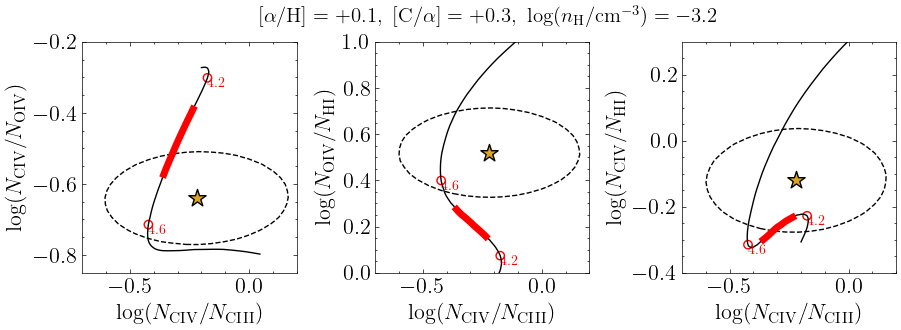

In [21]:
fig, axes = plt.subplots(1,3,figsize=(3.5*3,3), sharex=True)

corner.hist2d(logN_CIV_obs-logN_CIII_obs,logN_CIV_obs-logN_OIV_obs,levels=[2*cdf_1sig-1], bins=50, ax=axes[0], plot_datapoints=False, plot_density=False, contour_kwargs={'linestyles':'--'})
axes[0].scatter(12.78-13.0, 12.78-13.42, marker='*', s=170, edgecolor='black', facecolor='goldenrod')

C_alpha_test = 0.3
logN_HI_test = 12.9

for i in range(len(log_metals_list)):
    
    m = log_metals_list[i]

    logN_CIV_CIII = predict_col_dens_TDP('CIV', m, log_hdens_test, logT_range, logN_HI_test, logX_dict_TDP_interp)-predict_col_dens_TDP('CIII', m, log_hdens_test, logT_range, logN_HI_test, logX_dict_TDP_interp)
    logN_CIV_OIV = predict_col_dens_TDP('CIV', m, log_hdens_test, logT_range, logN_HI_test, logX_dict_TDP_interp)-predict_col_dens_TDP('OIV', m, log_hdens_test, logT_range, logN_HI_test, logX_dict_TDP_interp)+C_alpha_test

    idx = (logX_CIV_dict[m]>-5)&(logX_CIII_dict[m]>-5)&(logX_OIV_dict[m]>-5)
    axes[i].plot(logN_CIV_CIII[idx], logN_CIV_OIV[idx], color='black')

    idx_1 = (logX_CIV_dict[m]>-5)&(logX_CIII_dict[m]>-5)&(logX_OIV_dict[m]>-5)&(logT_range>4.37-0.08)&(logT_range<4.37+0.08)
    axes[i].plot(logN_CIV_CIII[idx_1], logN_CIV_OIV[idx_1], color='red', lw=5)
    
    logN_CIV_CIII_plot = predict_col_dens_TDP('CIV', m, log_hdens_test, logT_plot, logN_HI_test, logX_dict_TDP_interp)-predict_col_dens_TDP('CIII', m, log_hdens_test, logT_plot, logN_HI_test, logX_dict_TDP_interp)
    logN_CIV_OIV_plot = predict_col_dens_TDP('CIV', m, log_hdens_test, logT_plot, logN_HI_test, logX_dict_TDP_interp)-predict_col_dens_TDP('OIV', m, log_hdens_test, logT_plot, logN_HI_test, logX_dict_TDP_interp)+C_alpha_test

    for j in range(len(logT_plot)):
        if logX_CIV_plot_dict[m][j]>-5 and logX_CIII_plot_dict[m][j]>-5 and logX_OIV_plot_dict[m][j]>-5:
            axes[0].scatter(logN_CIV_CIII_plot[j], logN_CIV_OIV_plot[j], facecolor='none', edgecolor='red')
            axes[0].text(logN_CIV_CIII_plot[j], logN_CIV_OIV_plot[j], str(logT_plot[j]), color='red', fontsize=10, horizontalalignment='left', verticalalignment='top')

axes[0].set_ylim(-.85,-0.2)

axes[0].set_xlabel(r'$\log(N_\mathrm{CIV}/N_\mathrm{CIII})$')
axes[0].set_ylabel(r'$\log(N_\mathrm{CIV}/N_\mathrm{OIV})$')

corner.hist2d(logN_CIV_obs-logN_CIII_obs,logN_OIV_obs-logN_HI_obs,levels=[2*cdf_1sig-1], bins=50, ax=axes[1], plot_datapoints=False, plot_density=False, contour_kwargs={'linestyles':'--'})
axes[1].scatter(12.78-13.0, 13.42-12.9, marker='*', s=170, edgecolor='black', facecolor='goldenrod')

for i in range(len(log_metals_list)):
    
    m = log_metals_list[i]

    logN_CIV_CIII = predict_col_dens_TDP('CIV', m, log_hdens_test, logT_range, logN_HI_test, logX_dict_TDP_interp)-predict_col_dens_TDP('CIII', m, log_hdens_test, logT_range, logN_HI_test, logX_dict_TDP_interp)
    logN_OIV_HI = predict_col_dens_TDP('OIV', m, log_hdens_test, logT_range, logN_HI_test, logX_dict_TDP_interp)-logN_HI_test

    idx = (logX_CIV_dict[m]>-5)&(logX_CIII_dict[m]>-5)&(logX_OIV_dict[m]>-5)&(logX_HI_dict[m]>-5)
    axes[1].plot(logN_CIV_CIII[idx], logN_OIV_HI[idx], color='black')

    idx_1 = (logX_CIV_dict[m]>-5)&(logX_CIII_dict[m]>-5)&(logX_OIV_dict[m]>-5)&(logX_HI_dict[m]>-5)&(logT_range>4.37-0.08)&(logT_range<4.37+0.08)
    axes[1].plot(logN_CIV_CIII[idx_1], logN_OIV_HI[idx_1], color='red', lw=5)
    
    logN_CIV_CIII_plot = predict_col_dens_TDP('CIV', m, log_hdens_test, logT_plot, logN_HI_test, logX_dict_TDP_interp)-predict_col_dens_TDP('CIII', m, log_hdens_test, logT_plot, logN_HI_test, logX_dict_TDP_interp)
    logN_OIV_HI_plot = predict_col_dens_TDP('OIV', m, log_hdens_test, logT_plot, logN_HI_test, logX_dict_TDP_interp)-logN_HI_test

    for j in range(len(logT_plot)):
        if logX_CIV_plot_dict[m][j]>-5 and logX_CIII_plot_dict[m][j]>-5 and logX_OIV_plot_dict[m][j]>-5 and logX_HI_plot_dict[m][j]>-5:
            axes[1].scatter(logN_CIV_CIII_plot[j], logN_OIV_HI_plot[j], facecolor='none', edgecolor='red')
            axes[1].text(logN_CIV_CIII_plot[j], logN_OIV_HI_plot[j], str(logT_plot[j]), color='red', fontsize=10, horizontalalignment='left', verticalalignment='top')
            
axes[1].set_ylim(0.0,1.0)

axes[1].set_xlabel(r'$\log(N_\mathrm{CIV}/N_\mathrm{CIII})$')
axes[1].set_ylabel(r'$\log(N_\mathrm{OIV}/N_\mathrm{HI})$',labelpad=5)


corner.hist2d(logN_CIV_obs-logN_CIII_obs,logN_CIV_obs-logN_HI_obs,levels=[2*cdf_1sig-1], bins=50, ax=axes[2], plot_datapoints=False, plot_density=False, contour_kwargs={'linestyles':'--'})
axes[2].scatter(12.78-13.0, 12.78-12.9, marker='*', s=170, edgecolor='black', facecolor='goldenrod')

for i in range(len(log_metals_list)):
    
    m = log_metals_list[i]

    logN_CIV_CIII = predict_col_dens_TDP('CIV', m, log_hdens_test, logT_range, logN_HI_test, logX_dict_TDP_interp)-predict_col_dens_TDP('CIII', m, log_hdens_test, logT_range, logN_HI_test, logX_dict_TDP_interp)
    logN_CIV_HI = predict_col_dens_TDP('CIV', m, log_hdens_test, logT_range, logN_HI_test, logX_dict_TDP_interp)-logN_HI_test+C_alpha_test

    idx = (logX_CIV_dict[m]>-5)&(logX_CIII_dict[m]>-5)&(logX_HI_dict[m]>-5)
    axes[2].plot(logN_CIV_CIII[idx], logN_CIV_HI[idx], color='black')

    idx_1 = (logX_CIV_dict[m]>-5)&(logX_CIII_dict[m]>-5)&(logX_HI_dict[m]>-5)&(logT_range>4.37-0.08)&(logT_range<4.37+0.08)
    axes[2].plot(logN_CIV_CIII[idx_1], logN_CIV_HI[idx_1], color='red', lw=5)
    
    logN_CIV_CIII_plot = predict_col_dens_TDP('CIV', m, log_hdens_test, logT_plot, logN_HI_test, logX_dict_TDP_interp)-predict_col_dens_TDP('CIII', m, log_hdens_test, logT_plot, logN_HI_test, logX_dict_TDP_interp)
    logN_CIV_HI_plot = predict_col_dens_TDP('CIV', m, log_hdens_test, logT_plot, logN_HI_test, logX_dict_TDP_interp)-logN_HI_test+C_alpha_test

    for j in range(len(logT_plot)):
        if logX_CIV_plot_dict[m][j]>-5 and logX_CIII_plot_dict[m][j]>-5 and logX_HI_plot_dict[m][j]>-5:
            axes[2].scatter(logN_CIV_CIII_plot[j], logN_CIV_HI_plot[j], facecolor='none', edgecolor='red')
            axes[2].text(logN_CIV_CIII_plot[j], logN_CIV_HI_plot[j], str(logT_plot[j]), color='red', fontsize=10, horizontalalignment='left', verticalalignment='top')
            
axes[2].set_ylim(-.4,.3)

axes[2].set_xlabel(r'$\log(N_\mathrm{CIV}/N_\mathrm{CIII})$')
axes[2].set_ylabel(r'$\log(N_\mathrm{CIV}/N_\mathrm{HI})$')

axes[0].set_xlim(-0.7,0.2)

ax_label = fig.add_subplot(111, frameon=False)
ax_label.set_xticks([])
ax_label.set_yticks([])
ax_label.set_title(r'$\mathrm{[\alpha/H]}=+0.1, \ \mathrm{[C/\alpha]}=+0.3, \ \log(n_\mathrm{H}/\mathrm{cm}^{-3})=-3.2$',
                   fontsize=15, y=1.05)

plt.subplots_adjust(wspace=0.4, hspace=0.0)

pos = axes[1].get_position()
new_pos = [pos.x0-0.0067, pos.y0, pos.width, pos.height]
axes[1].set_position(new_pos)